# Project Overview

## Project Topic

#### Explanation
The project aims to provide insights into the effectiveness and applicability of forecasting techniques in capturing seasonal variations and other temporal patterns specific to Winnipeg's climate. This endeavor ultimately seeks to enhance our understanding of temperature dynamics and support informed decision-making in various sectors impacted by weather conditions.

#### Goal
Develop and compare two time series forecasting models to predict the average temperature for Winnipeg, Canada. Utilizing the "Daily Temperature of Major Cities" dataset available on [Kaggle](https://www.kaggle.com/), our objective is to implement SARIMA (Seasonal Autoregressive Integrated Moving Average) and Prophet models. These models will be trained and evaluated to achieve accurate predictions of temperature trends in Winnipeg.  

This information and a well-trained model could help the population understand the impacts of temperature rise. For instance, [Global temperature rise projections](https://decarbonization.visualcapitalist.com/mapped-global-temperature-rise-by-country/) suggest that, on average, the temperature will increase by 2.75 degrees Celsius until 2050. The temperature rise will cause more frequent and intense extreme weather events, nearly all ecosystems will face high risks of biodiversity loss, accelerated sea level rise will threaten coastal cities, and so on.  

## Data
[Daily Temperature of Major Cities](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities)

#### Source
The dataset is from Kaggle website (public source). It contains historical day level average temperature (Fahrenheit) of 321 cities from 1995 to 2020 in CSV format. The dataset has 2,906,327 rows and 8 columns.

#### Data Dicitionary
|Field           | Definition                                        | Format  |Examples             |
|----------------|---------------------------------------------------|---------|---------------------|
| Region         | Region of the world                               | object  |South America, Europe|
| Country        | Region of the world                               | object  |Canada,  Uruguay     |
| State          | Country State                                     | object  |Hawaii, New Jersey   |
| City           | City of observation                               | object  |Madrid, Budapest     |
| Month          | Month of observation                              | int64   |1,2,3, ...,10,11,12  |
| Day            | Day of observation                                | int64   |1,2,3, ..., 29,30,31 |
| Year           | Year of Observation                               | int64   |1995, 1996,..., 2020 |
| AvgTemperature | Average temperature on the given day (Fahrenheit) | float64 |-99, 25.3, 82.4      |

### Import Libraries

In [1]:
#data cleaning and analysis
import numpy as np
import pandas as pd
import datetime
from math import sqrt
# from ydata_profiling import ProfileReport

#data visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# modeling & evaluation
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# other
import tqdm as notebook_tqdm # auto-save jupyter notebook
import warnings # ignore warning messages
warnings.filterwarnings("ignore") 
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/anaconda3/envs/py_n/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Dataset

In [2]:
city_temp = pd.read_csv("/Users/hugobritto/Desktop/MSDS/intro_ml/dataset/city_temperature.csv",\
                        low_memory=False)

In [3]:
# check fields from the dataset
city_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [4]:
# check some records from the top
city_temp.head(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [5]:
# check some records from the end
city_temp.tail(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8
2906326,North America,US,Additional Territories,San Juan Puerto Rico,7,31,2013,83.6


In [6]:
# check some records randomly
city_temp.sample(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
254966,Asia,Bangladesh,NaN,Dhaka,7,15,2005,78.3
2886972,North America,US,Wyoming,Casper,4,29,2011,40.3
142592,Africa,Malawi,NaN,Lilongwe,8,17,1999,61.4
306579,Asia,Hong Kong,NaN,Hong Kong,2,5,2004,50.9
872781,Europe,Romania,NaN,Bucharest,5,19,2005,64.3


## Data Cleaning

In [7]:
# Check for duplicated values
city_temp.duplicated().sum()

20715

In [8]:
# check a sample of duplicated records
city_temp[city_temp.duplicated()].sample(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1704639,North America,US,Maryland,Washington DC,10,11,2017,74.5
1701253,North America,US,Maryland,Washington DC,7,4,2008,80.2
1696710,North America,US,Maryland,Washington DC,1,26,1996,32.8
1680153,North America,US,District of Columbia,Washington,6,21,2001,79.0
1701031,North America,US,Maryland,Washington DC,11,25,2007,42.9


In [9]:
# drop duplicates
city_temp = city_temp.drop_duplicates(keep=False)

# Check for duplicated values
city_temp.duplicated().sum()

0

In [10]:
# Total missing values for each feature
city_temp.isna().sum()

Region                  0
Country                 0
State             1447010
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

The State column is missing 1,447,010 rows

In [11]:
# Drop fields not relevant for the project
city_temp = city_temp.drop(['Region', 'State'], axis=1)

city_temp.head()

,Country,City,Month,Day,Year,AvgTemperature
0,Algeria,Algiers,1,1,1995,64.2
1,Algeria,Algiers,1,2,1995,49.4
2,Algeria,Algiers,1,3,1995,48.8
3,Algeria,Algiers,1,4,1995,46.4
4,Algeria,Algiers,1,5,1995,47.9


In [12]:
# Check unique values for each field to verify if the data set contains wrong data
for c in city_temp.columns:
    print("===============================================================================")
    print("field: ", c)
    print("unique values:", np.sort(city_temp[c].unique()), "\n")

field:  Country
unique values: ['Albania' 'Algeria' 'Argentina' 'Australia' 'Austria' 'Bahamas' 'Bahrain'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda'
 'Bolivia' 'Brazil' 'Bulgaria' 'Burundi' 'Canada'
 'Central African Republic' 'China' 'Colombia' 'Congo' 'Costa Rica'
 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark' 'Dominican Republic'
 'Egypt' 'Equador' 'Ethiopia' 'Finland' 'France' 'Gabon' 'Gambia'
 'Georgia' 'Germany' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau'
 'Guyana' 'Haiti' 'Honduras' 'Hong Kong' 'Hungary' 'Iceland' 'India'
 'Indonesia' 'Ireland' 'Israel' 'Italy' 'Ivory Coast' 'Japan' 'Jordan'
 'Kazakhstan' 'Kenya' 'Kuwait' 'Kyrgyzstan' 'Laos' 'Latvia' 'Lebanon'
 'Macedonia' 'Madagascar' 'Malawi' 'Malaysia' 'Mauritania' 'Mexico'
 'Mongolia' 'Morocco' 'Mozambique' 'Myanmar (Burma)' 'Namibia' 'Nepal'
 'New Zealand' 'Nicaragua' 'Nigeria' 'North Korea' 'Norway' 'Oman'
 'Pakistan' 'Panama' 'Peru' 'Philippines' 'Poland' 'Portugal' 'Qatar'
 'Romania'

the Day field has records with 0 and Year field has 200 and 201 years. Let's check how many records with those cases.

In [13]:
# check values for Year field
print(city_temp["Year"].value_counts().sort_index(),"\n")

Year
200         31
201        177
1995    117156
1996    117485
1997    117196
1998    117622
1999    117895
2000    118218
2001    117895
2002    117895
2003    117680
2004    117181
2005    116435
2006    116187
2007    113942
2008    112754
2009    112787
2010    113439
2011    111218
2012    110529
2013    109561
2014    107558
2015    106038
2016    105773
2017    105486
2018    104622
2019    104253
2020     38274
Name: count, dtype: int64 



In [14]:
31+177

208

In [15]:
# Check sample of rows with  200 Year 
city_temp[city_temp["Year"] == 200].sample(5)

,Country,City,Month,Day,Year,AvgTemperature
845921,Norway,Oslo,12,13,200,-99.0
845934,Norway,Oslo,12,26,200,-99.0
845923,Norway,Oslo,12,15,200,-99.0
845932,Norway,Oslo,12,24,200,-99.0
845919,Norway,Oslo,12,11,200,-99.0


In [16]:
# Check sample of rows with  201 Year 
city_temp[city_temp["Year"] == 201].sample(5)

,Country,City,Month,Day,Year,AvgTemperature
58203,Ethiopia,Addis Ababa,12,28,201,-99.0
111979,Kenya,Nairobi,12,6,201,-99.0
155019,Mozambique,Maputo,12,23,201,-99.0
155011,Mozambique,Maputo,12,15,201,-99.0
112004,Kenya,Nairobi,12,31,201,-99.0


Only 208 rows have this type of error. This corresponds to 0.007% of the total of rows (2,906,327). In other words, it will not affect the results. Let's drop those records in the next step.

In [17]:
# Remove 200 and 201 as years from the data set
city_temp = city_temp.query("Year not in (200, 201)")

#Check values for Year field
print(city_temp["Year"].value_counts().sort_index(),"\n")

Year
1995    117156
1996    117485
1997    117196
1998    117622
1999    117895
2000    118218
2001    117895
2002    117895
2003    117680
2004    117181
2005    116435
2006    116187
2007    113942
2008    112754
2009    112787
2010    113439
2011    111218
2012    110529
2013    109561
2014    107558
2015    106038
2016    105773
2017    105486
2018    104622
2019    104253
2020     38274
Name: count, dtype: int64 



In [18]:
#Check values for Day field
print(city_temp["Day"].value_counts().sort_index(),"\n")

Day
0         8
1     94298
2     94305
3     94311
4     94312
5     94312
6     94310
7     94310
8     94310
9     94306
10    94305
11    94306
12    94299
13    94273
14    94018
15    94021
16    94015
17    94015
18    94016
19    94013
20    94012
21    94016
22    94014
23    94005
24    94005
25    94005
26    94008
27    94002
28    93999
29    88109
30    86108
31    54733
Name: count, dtype: int64 



In [19]:
city_temp[city_temp["Day"] == 0].sample(8)

,Country,City,Month,Day,Year,AvgTemperature
1209901,Mexico,Guadalajara,3,0,2012,-99.0
82774,Guinea,Conakry,3,0,2008,-99.0
85697,Guinea,Conakry,3,0,2016,-99.0
1333910,Cuba,Havana,3,0,2008,-99.0
92041,Guinea-Bissau,Bissau,3,0,2008,-99.0
241159,Uganda,Kampala,3,0,2012,-99.0
177862,Nigeria,Lagos,3,0,2008,-99.0
146077,Malawi,Lilongwe,3,0,2012,-99.0


Only eight rows have this type of error. Let's drop those records in the next step.

In [20]:
# remove rows with 0 as day from the data set
city_temp = city_temp.query("Day != 0")

#Check values for Year field:")
print(city_temp["Day"].value_counts().sort_index(),"\n")

Day
1     94298
2     94305
3     94311
4     94312
5     94312
6     94310
7     94310
8     94310
9     94306
10    94305
11    94306
12    94299
13    94273
14    94018
15    94021
16    94015
17    94015
18    94016
19    94013
20    94012
21    94016
22    94014
23    94005
24    94005
25    94005
26    94008
27    94002
28    93999
29    88109
30    86108
31    54733
Name: count, dtype: int64 



Another thing that caught my attention was the average temperature of -99 degrees Fahrenheit for countries in Africa. It seems the owner of the dataset replaced NULL values for -99. Let's investigate it more.

In [21]:
# check AvgTemperature descriptive stats 
pd.set_option('float_format', '{:f}'.format) #show all digits 
city_temp['AvgTemperature'].describe()

count   2865071.000000
mean         56.030833
std          32.168791
min         -99.000000
25%          45.800000
50%          62.500000
75%          75.600000
max         110.000000
Name: AvgTemperature, dtype: float64

In [22]:
# check AvgTemperature values
# pd.set_option("display.max_rows", None)
city_temp["AvgTemperature"].value_counts()

AvgTemperature
-99.000000    78726
80.200000      7358
80.800000      7326
79.200000      7173
81.100000      7151
              ...  
-45.600000        1
-35.400000        1
-39.400000        1
-33.100000        1
-36.700000        1
Name: count, Length: 1517, dtype: int64

In [23]:
# create a subset of the df with -99 AvgTemperature
city_temp_99 = city_temp[city_temp["AvgTemperature"] == -99]

city_temp_99.head()

,Country,City,Month,Day,Year,AvgTemperature
220,Algeria,Algiers,8,9,1995,-99.000000
221,Algeria,Algiers,8,10,1995,-99.000000
408,Algeria,Algiers,2,13,1996,-99.000000
409,Algeria,Algiers,2,14,1996,-99.000000
1453,Algeria,Algiers,12,24,1998,-99.000000


In [24]:
# gather counts for countries with -99 AvgTemperature
city_temp_99.groupby(["Country"])["AvgTemperature"].count()

Country
Albania       1618
Algeria         35
Argentina       35
Australia      328
Austria         26
              ... 
Uzbekistan     100
Venezuela      144
Vietnam         36
Yugoslavia      30
Zambia         584
Name: AvgTemperature, Length: 125, dtype: int64

In [25]:
# gather counts for years with -99 AvgTemperature
city_temp_99.groupby(["Year"])["AvgTemperature"].count()

Year
1995    6464
1996    6215
1997    5704
1998    7964
1999    5945
2000    5513
2001    4078
2002    5719
2003    4849
2004    4048
2005    3120
2006    3446
2007    2218
2008    2172
2009    1266
2010    1819
2011    1105
2012     825
2013     793
2014    1158
2015     689
2016     833
2017     525
2018     946
2019    1244
2020      68
Name: AvgTemperature, dtype: int64

Above, we saw the -99 temperature affects several rows. We will replace the -99 for the average daily temperature to be the same as the previous day for the cities. This approach will fix the issue and help to improve the results.

In [26]:
# Replace -99 AvgTemperature for NaN values
city_temp['AvgTemperature_2'] = city_temp['AvgTemperature'].replace(-99, np.NaN)

# Replace NaN values for the average daily temperature is same as the previous day for the cities
city_temp['AvgTemperature_2'].ffill(inplace=True)

# check a sample of records for one country
city_temp.query("AvgTemperature == -99 & Country == 'Canada'").sample(5)

,Country,City,Month,Day,Year,AvgTemperature,AvgTemperature_2
1172197,Canada,Quebec,12,31,2015,-99.000000,16.300000
1168975,Canada,Quebec,3,7,2007,-99.000000,21.700000
1178807,Canada,Regina,9,24,2008,-99.000000,43.800000
1135198,Canada,Calgary,11,30,2008,-99.000000,34.100000
1168209,Canada,Quebec,1,30,2005,-99.000000,17.900000


In [27]:
# check descriptive stats for the AvgTemperature & AvgTemperature_2
city_temp[['AvgTemperature', 'AvgTemperature_2']].describe()

,AvgTemperature,AvgTemperature_2
count,2865071.000000,2865071.000000
mean,56.030833,60.723641
std,32.168791,19.123111
min,-99.000000,-50.000000
25%,45.800000,47.800000
50%,62.500000,63.700000
75%,75.600000,76.300000
max,110.000000,110.000000


<Axes: >

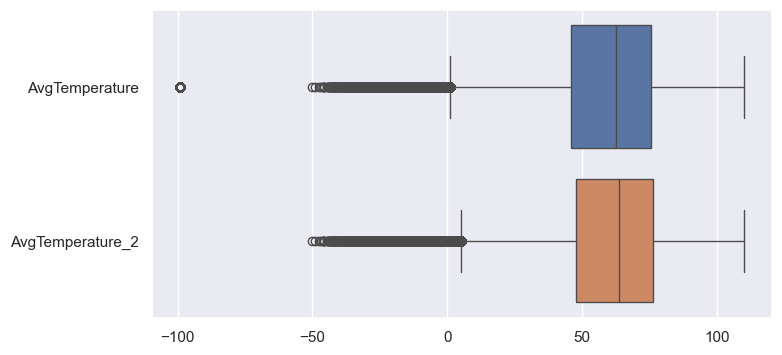

In [28]:
# Check the distribution of temperature
sns.set(rc={"figure.figsize":(8, 4)}) #set up figure size for seaboarn graphs
sns.boxplot(city_temp[['AvgTemperature','AvgTemperature_2']], orient="h")

<Axes: >

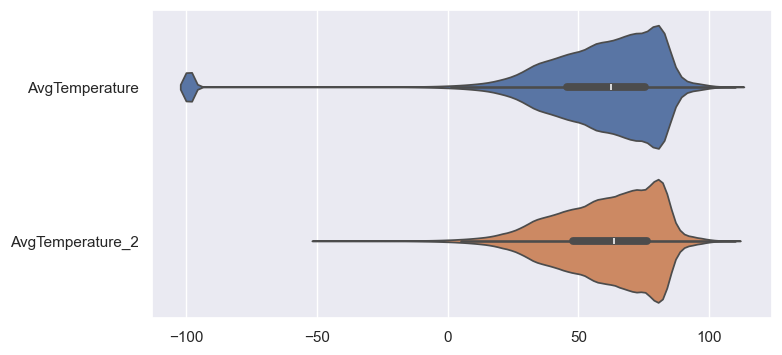

In [29]:
# Check the distribution of temperature
sns.violinplot(city_temp[['AvgTemperature','AvgTemperature_2']], orient="h")

<Axes: xlabel='AvgTemperature', ylabel='Count'>

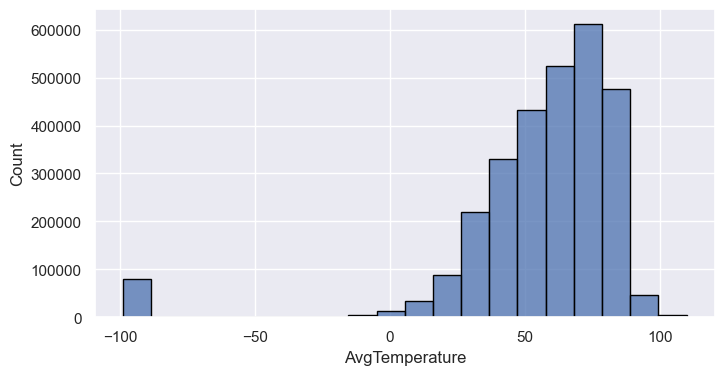

In [30]:
# Check the distribution of temperature
sns.histplot(city_temp['AvgTemperature'], bins=20, edgecolor='black')

<Axes: xlabel='AvgTemperature_2', ylabel='Count'>

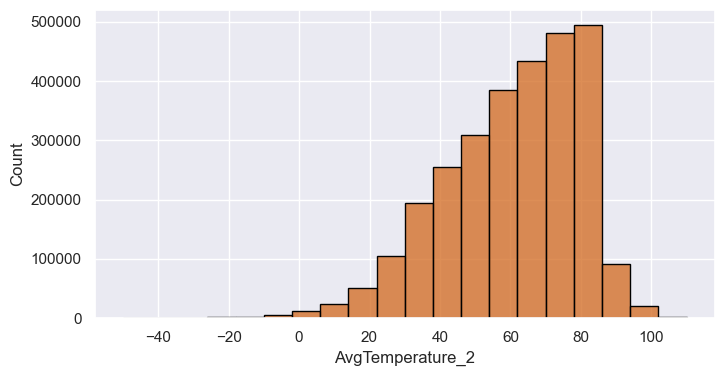

In [31]:
sns.histplot(city_temp['AvgTemperature_2'], color= 'chocolate', bins=20, edgecolor='black')

All charts indicate that the value "-99" was used by the dataset owner to represent null values. By replacing "-99" with the average daily temperature of the previous day for each city, the distribution of the data was altered. For example, the original column showed 50% of the data at 62.5 degrees Fahrenheit, whereas the modified column-averaged 63.7 degrees Fahrenheit.
Additionally, utilizing boxplots and violin plots, temperatures below 0 degrees Fahrenheit were identified as outliers, reflecting that most cities experience mild temperatures. The histogram reveals a left-skewed distribution, indicating that most temperature records fall between 60 and 80 degrees Fahrenheit.
Comparing both columns of average temperatures, the adjusted AvgTemperature column demonstrates a more evenly distributed pattern comparing the original dataset.

In the next step, I will convert the temperatures from Fahrenheit type to Celcius because I am more familar with Celcius. 

In [32]:
#create date column from year, month, and day columns
city_temp['date'] = pd.to_datetime(dict(year=city_temp.Year, month=city_temp.Month, day=city_temp.Day))

# Convert Fahrenheit temperature to Celcius
city_temp['Avg_Temp_Celcius'] = round(((city_temp['AvgTemperature_2'] - 32) * 5/9), 1)

# check records
city_temp.head()

,Country,City,Month,Day,Year,AvgTemperature,AvgTemperature_2,date,Avg_Temp_Celcius
0,Algeria,Algiers,1,1,1995,64.200000,64.200000,1995-01-01,17.900000
1,Algeria,Algiers,1,2,1995,49.400000,49.400000,1995-01-02,9.700000
2,Algeria,Algiers,1,3,1995,48.800000,48.800000,1995-01-03,9.300000
3,Algeria,Algiers,1,4,1995,46.400000,46.400000,1995-01-04,8.000000
4,Algeria,Algiers,1,5,1995,47.900000,47.900000,1995-01-05,8.800000


## Exploratory Data Analysis (EDA)

In [33]:
# check descriptive stats for the AvgTemperature, AvgTemperature_2, Avg_Temp_Celcius
city_temp[['AvgTemperature', 'AvgTemperature_2','Avg_Temp_Celcius']].describe()

,AvgTemperature,AvgTemperature_2,Avg_Temp_Celcius
count,2865071.000000,2865071.000000,2865071.000000
mean,56.030833,60.723641,15.957537
std,32.168791,19.123111,10.623908
min,-99.000000,-50.000000,-45.600000
25%,45.800000,47.800000,8.800000
50%,62.500000,63.700000,17.600000
75%,75.600000,76.300000,24.600000
max,110.000000,110.000000,43.300000


<Axes: xlabel='Avg_Temp_Celcius'>

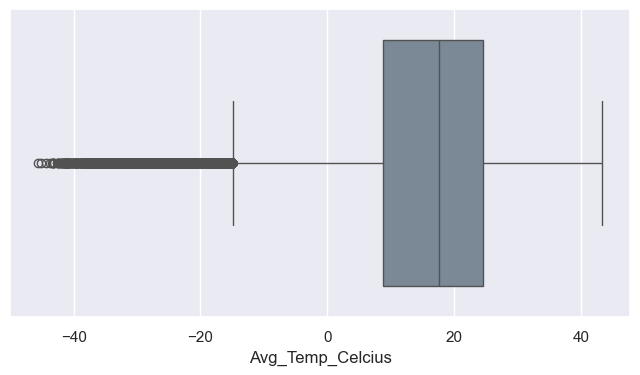

In [34]:
# Check the distribution of temperature
sns.boxplot(city_temp['Avg_Temp_Celcius'], orient="h", color= 'lightslategray')

<Axes: xlabel='Avg_Temp_Celcius'>

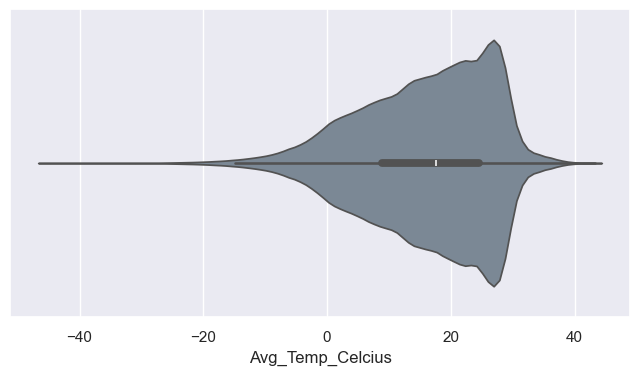

In [35]:
# Check the distribution of temperature
sns.violinplot(city_temp['Avg_Temp_Celcius'], orient="h", color= 'lightslategray')

<Axes: xlabel='Avg_Temp_Celcius', ylabel='Count'>

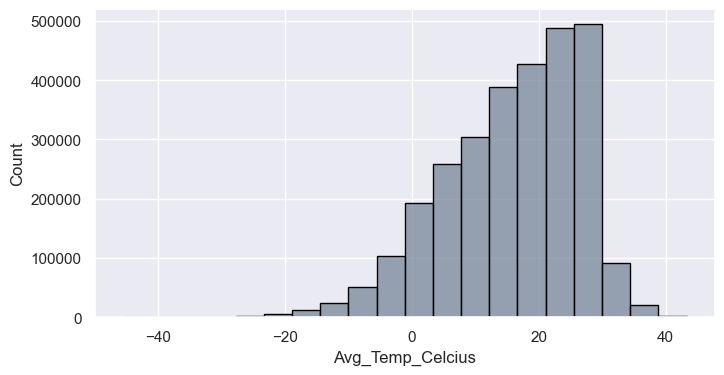

In [36]:
# Check the distribution of temperature
sns.histplot(city_temp['Avg_Temp_Celcius'], color= 'lightslategray', bins=20, edgecolor='black')

The plots depicting average temperatures in Celsius show distributions similar to those found in AvgTemperature_2, as expected. However, there have been changes in the limits. Average temperatures now range from 40 degrees Celsius to -40 degrees Celsius, with 50% of the population at 17.6 degrees Celsius. Notably, temperatures below -19 degrees Celsius are now considered as outliers.

In the next section, we will analyze the average temperature trends over time for cities worldwide. Our goal is to interpret how the average temperatures of each city have fluctuated from 1995 to 2019.

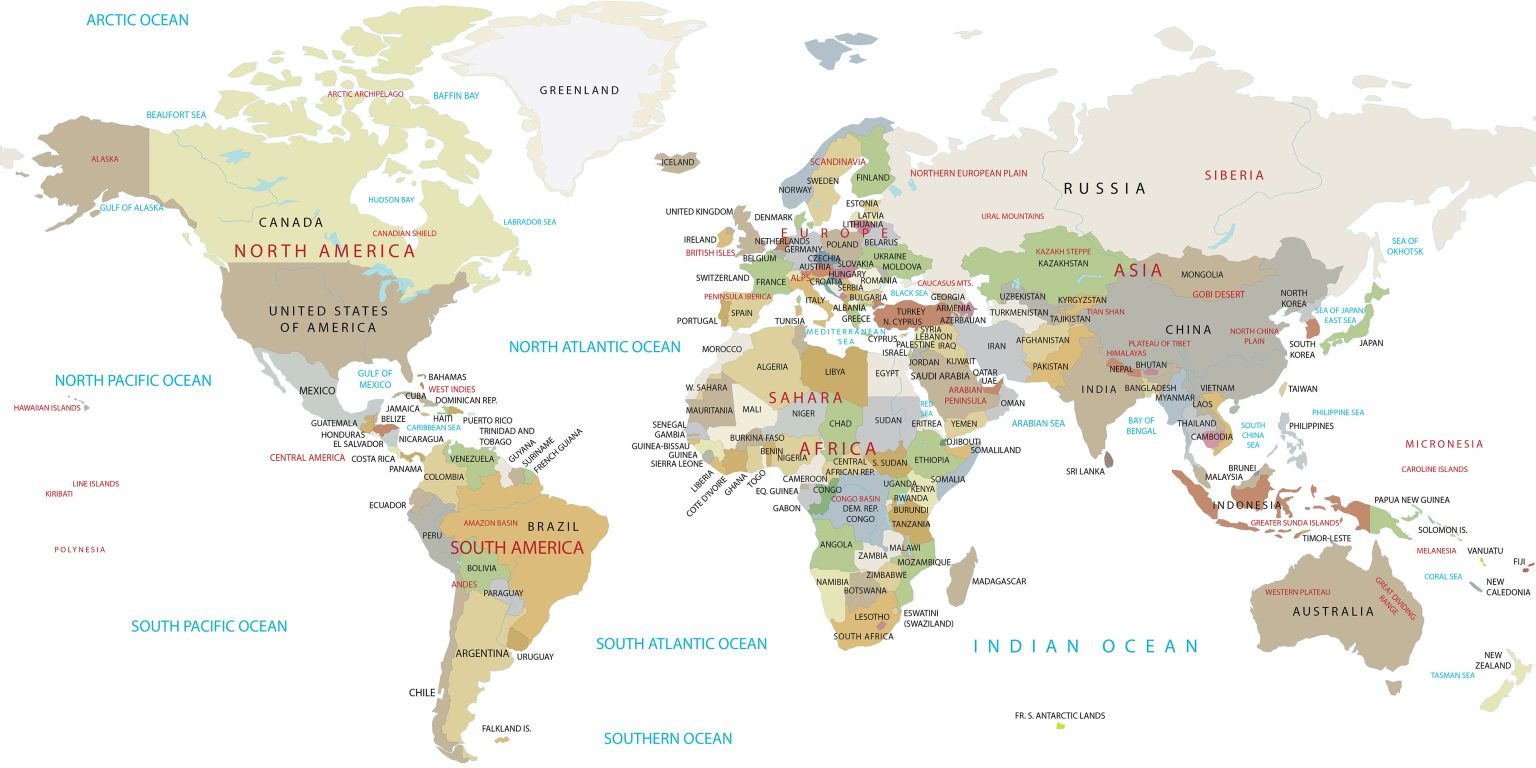

In [37]:
# Add image of world map
from IPython import display
display.Image("/Users/hugobritto/Desktop/MSDS/intro_ml/images/World-Map.jpg")

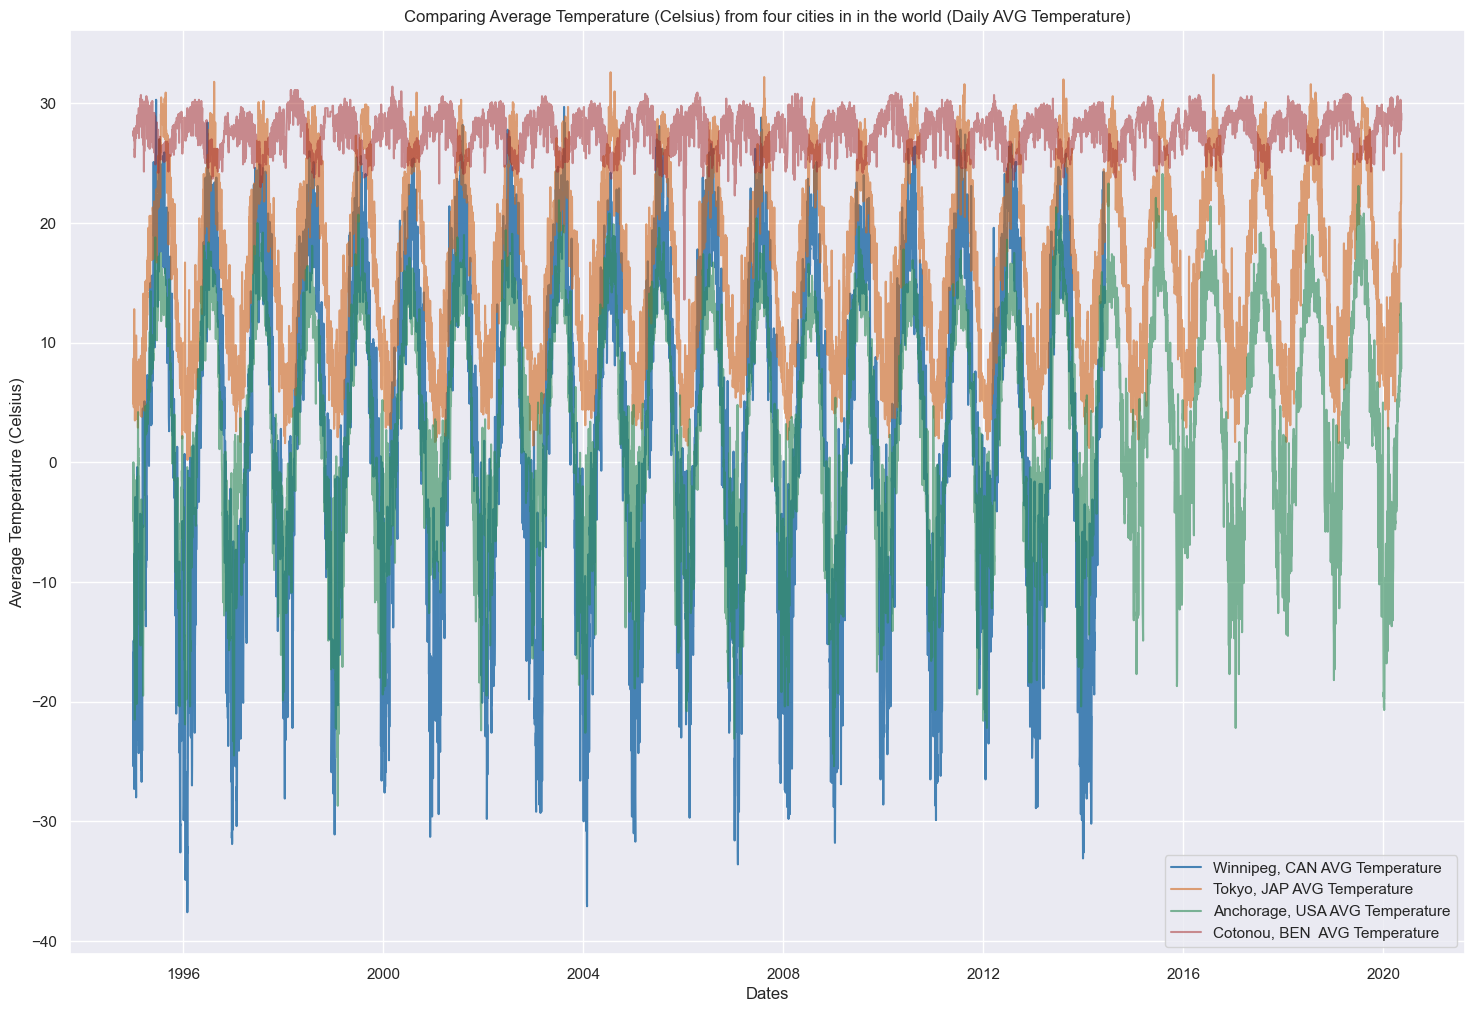

In [38]:
# create each plot line
anchorage_temps =  city_temp[city_temp['City']=='Anchorage'].reset_index(drop=True)
tokyo_temps =  city_temp[city_temp['City']=='Tokyo'].reset_index(drop=True)
winnipeg_temps  =  city_temp[city_temp['City']=='Winnipeg'].reset_index(drop=True)
cotonou_temps = city_temp[city_temp['City']=='Cotonou'].reset_index(drop=True)

# create line graph
sns.set(rc={"figure.figsize":(18, 12)}) #set up figure size for seaboarn graphs
sns.lineplot(x='date', y='Avg_Temp_Celcius', data=winnipeg_temps  , label='Winnipeg, CAN AVG Temperature', \
              color = 'steelblue')
sns.lineplot(x='date', y='Avg_Temp_Celcius', data=tokyo_temps, label='Tokyo, JAP AVG Temperature',\
            alpha = 0.6, color = 'chocolate')
sns.lineplot(x='date', y='Avg_Temp_Celcius', data=anchorage_temps, label='Anchorage, USA AVG Temperature', \
             alpha = 0.6, color = 'seagreen')

sns.lineplot(x='date', y='Avg_Temp_Celcius', data=cotonou_temps, label='Cotonou, BEN  AVG Temperature',\
             alpha = 0.5, color = 'brown')
plt.title("Comparing Average Temperature (Celsius) from four cities in in the world (Daily AVG Temperature)")
plt.xlabel("Dates")
plt.ylabel("Average Temperature (Celsius)")
plt.legend()

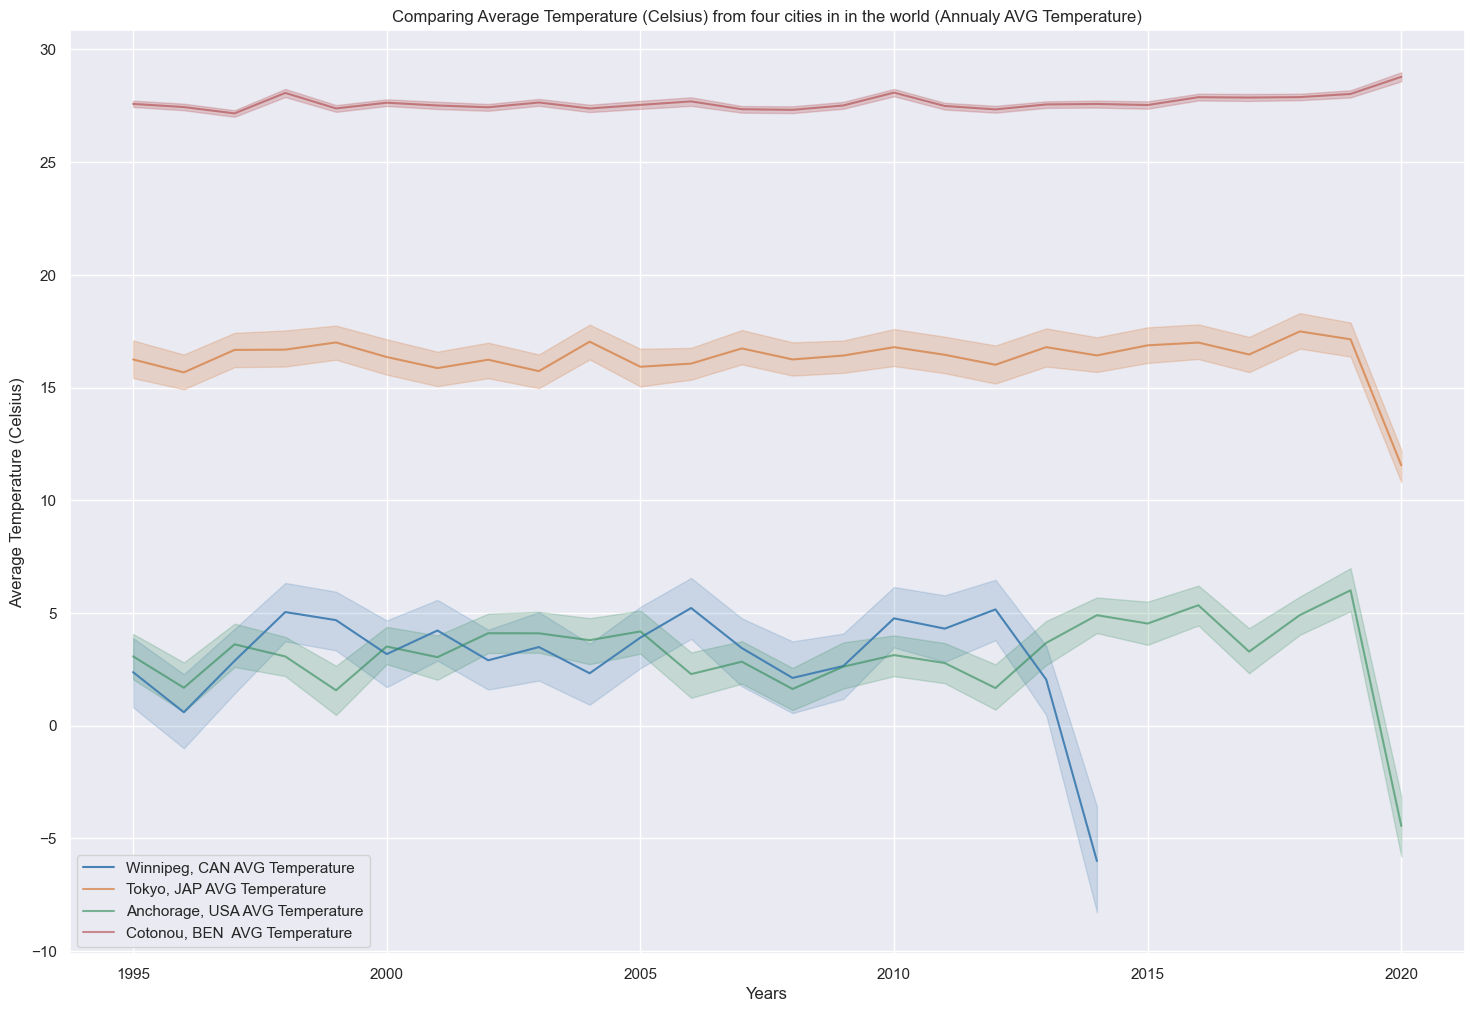

In [39]:
# create each plot line data
anchorage_temps =  city_temp[city_temp['City']=='Anchorage'].reset_index(drop=True)
tokyo_temps =  city_temp[city_temp['City']=='Tokyo'].reset_index(drop=True)
winnipeg_temps  =  city_temp[city_temp['City']=='Winnipeg'].reset_index(drop=True)
cotonou_temps = city_temp[city_temp['City']=='Cotonou'].reset_index(drop=True)

# create line graph
sns.set(rc={"figure.figsize":(18, 12)}) #set up figure size for seaboarn graphs
sns.lineplot(x='Year', y='Avg_Temp_Celcius', data=winnipeg_temps  , label='Winnipeg, CAN AVG Temperature', \
              color = 'steelblue')
sns.lineplot(x='Year', y='Avg_Temp_Celcius', data=tokyo_temps, label='Tokyo, JAP AVG Temperature',\
            alpha = 0.6, color = 'chocolate')
sns.lineplot(x='Year', y='Avg_Temp_Celcius', data=anchorage_temps, label='Anchorage, USA AVG Temperature', \
             alpha = 0.6, color = 'seagreen')

sns.lineplot(x='Year', y='Avg_Temp_Celcius', data=cotonou_temps, label='Cotonou, BEN  AVG Temperature',\
             alpha = 0.5, color = 'brown')
plt.title("Comparing Average Temperature (Celsius) from four cities in in the world (Annualy AVG Temperature)")
plt.xlabel("Years")
plt.ylabel("Average Temperature (Celsius)")
plt.legend()

The Earth's shape and movement provide a unique phenomenon where countries in different hemispheres experience opposite seasons simultaneously. While Europe faces winter, Brazil enjoys summer. The data confirms our geographical understanding: temperatures decrease as we move farther from the equator. From 1995 to 2019, average temperatures have risen across all regions.

In Cotonou, Africa, temperatures have shown a stable trend with gentle fluctuations. Tokyo experiences mild temperature oscillations compared to Winnipeg and Anchorage.

Winnipeg exhibits significant spikes in temperature during winter and summer, ranging from -38 to 30 degrees Celsius, marking a 68-degree Celsius change throughout the year. This pronounced seasonality makes Winnipeg's average temperature data ideal for training time series models.

In the next section, we will analyze the average temperature trends over time for cities in Canada. Our goal is to interpret how the average temperatures of each city have fluctuated from 1995 to 2019. I selected Vancouver, Winnipeg, and Montreal based on their geographic locations. Vancouver is on the extreme left of the Canada map, Winnipeg in the middle, and Montreal on the far right. Let's examine how temperature changes correlate with each city's location.

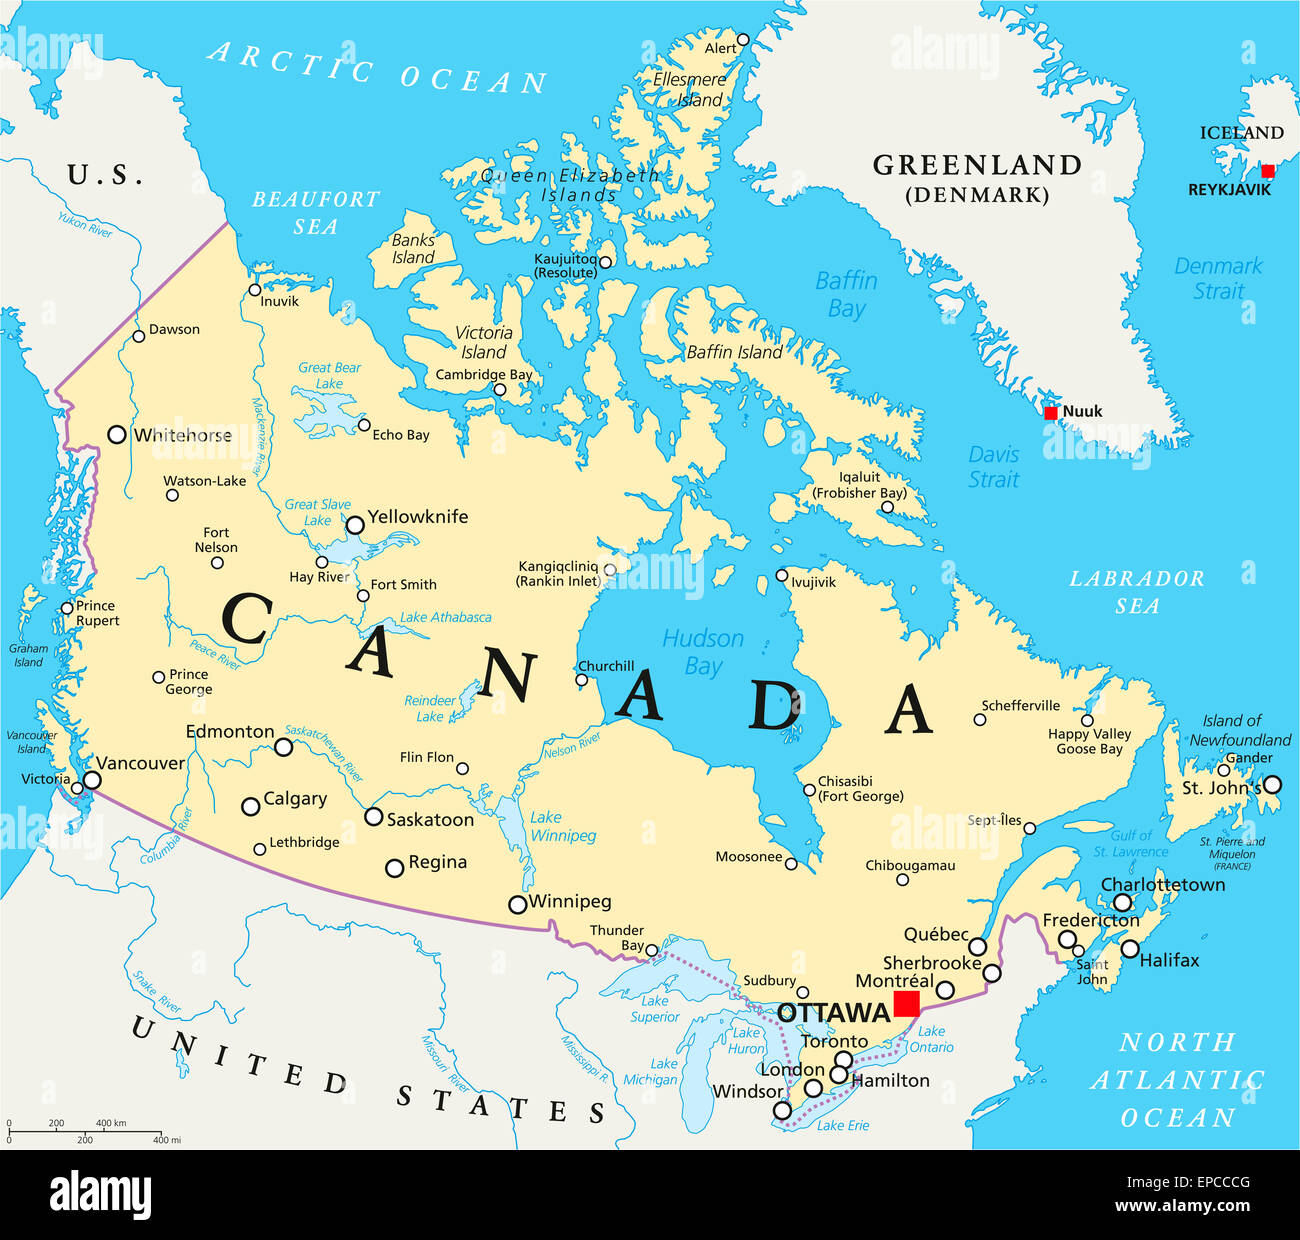

In [40]:
# Embed Canada Map image
display.Image("/Users/hugobritto/Desktop/MSDS/intro_ml/images/canada_map.jpg")

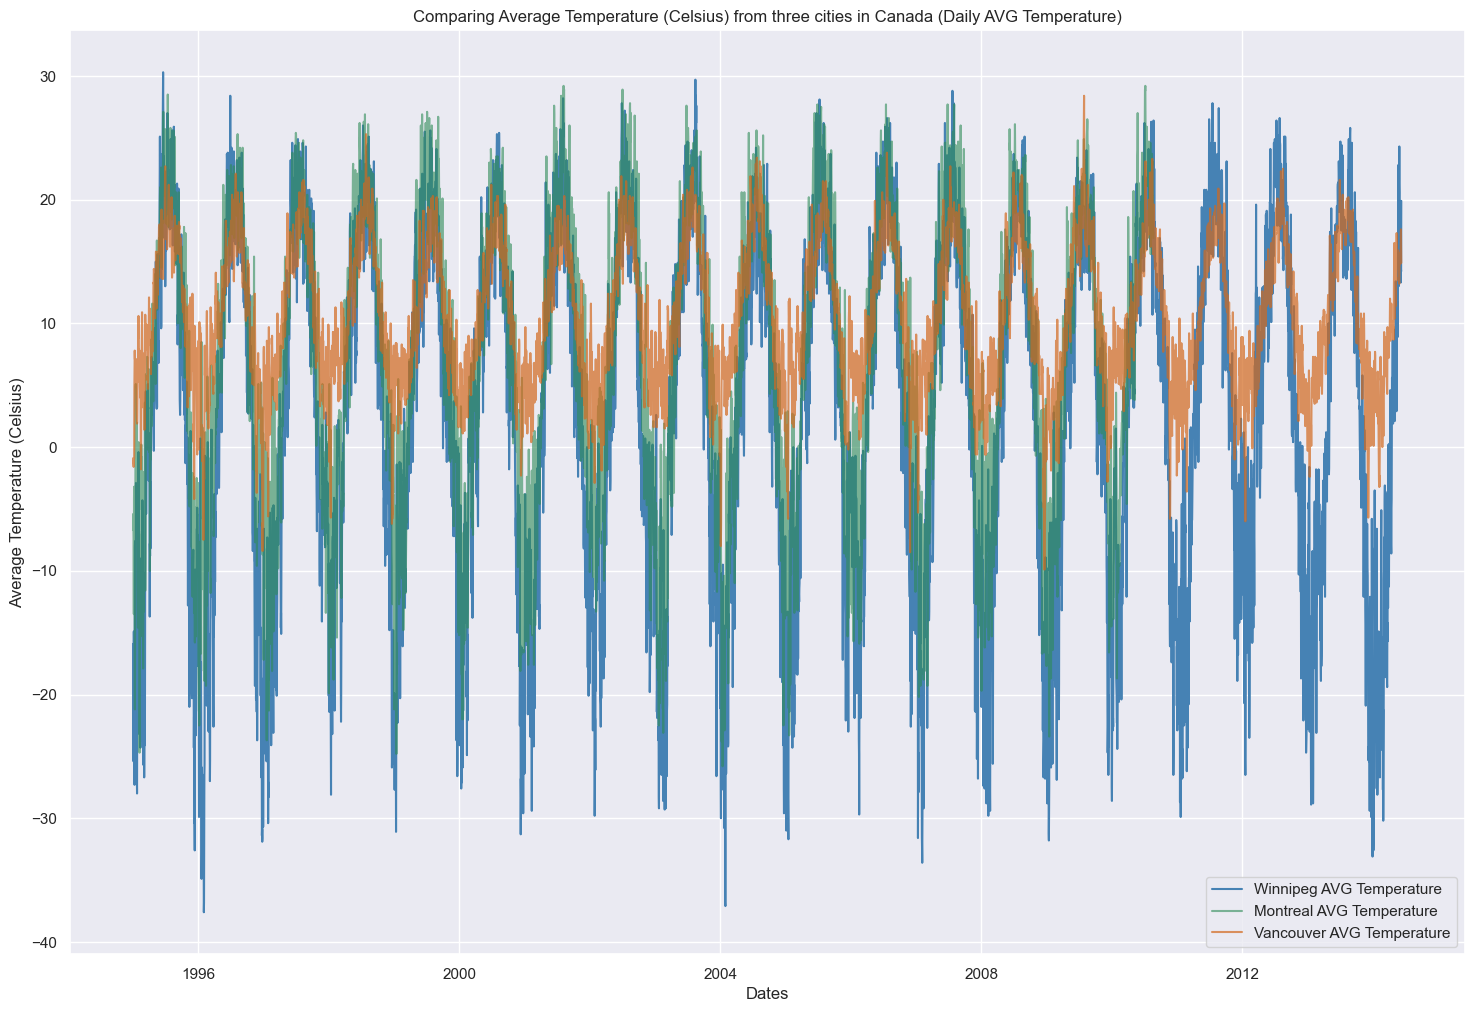

In [41]:
# create each plot line data
montreal_temps =  city_temp[city_temp['City']=='Montreal'].reset_index(drop=True)
vancouver_temps = city_temp[city_temp['City']=='Vancouver'].reset_index(drop=True)

# create line graph
sns.set(rc={"figure.figsize":(18, 12)}) #set up figure size for seaboarn graphs
sns.lineplot(x='date', y='Avg_Temp_Celcius', data=winnipeg_temps  , label='Winnipeg AVG Temperature', \
              color = 'steelblue')
sns.lineplot(x='date', y='Avg_Temp_Celcius', data=montreal_temps , label='Montreal AVG Temperature', \
             alpha = 0.6,color = 'seagreen')
sns.lineplot(x='date', y='Avg_Temp_Celcius', data=vancouver_temps, label='Vancouver AVG Temperature',\
             alpha = 0.7, color = 'chocolate')
plt.title("Comparing Average Temperature (Celsius) from three cities in Canada (Daily AVG Temperature)")
plt.xlabel("Dates")
plt.ylabel("Average Temperature (Celsius)")
plt.legend()

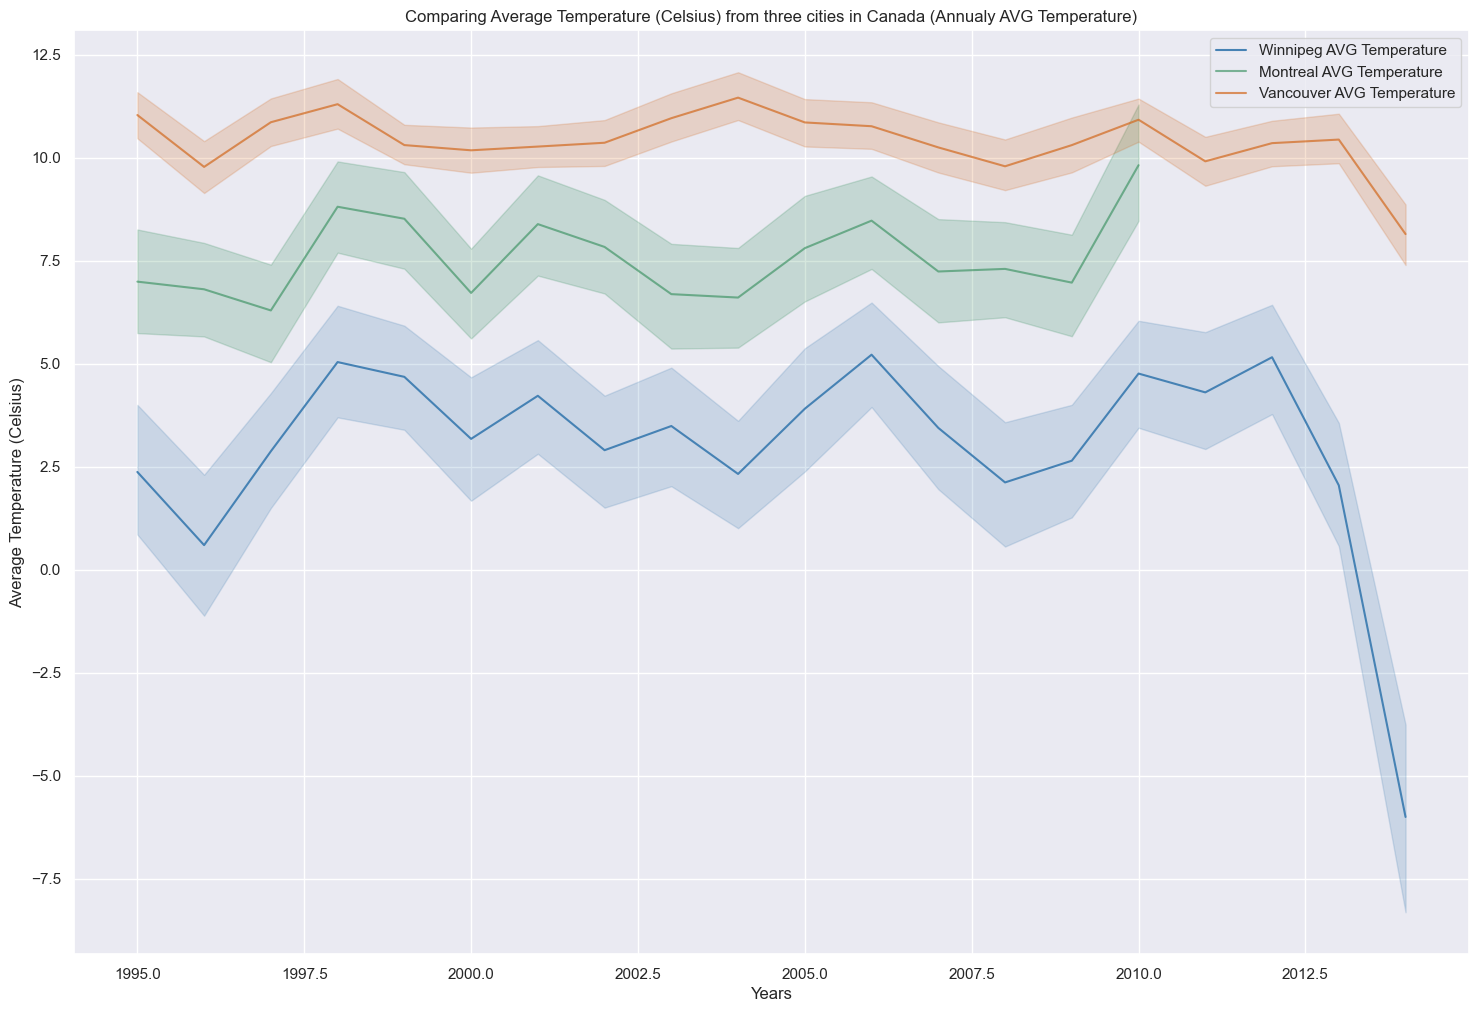

In [42]:
# create each plot line data
montreal_temps =  city_temp[city_temp['City']=='Montreal'].reset_index(drop=True)
vancouver_temps = city_temp[city_temp['City']=='Vancouver'].reset_index(drop=True)

# create line graph
sns.set(rc={"figure.figsize":(18, 12)}) #set up figure size for seaboarn graphs
sns.lineplot(x='Year', y='Avg_Temp_Celcius', data=winnipeg_temps  , label='Winnipeg AVG Temperature', \
              color = 'steelblue')
sns.lineplot(x='Year', y='Avg_Temp_Celcius', data=montreal_temps , label='Montreal AVG Temperature', \
             alpha = 0.6,color = 'seagreen')
sns.lineplot(x='Year', y='Avg_Temp_Celcius', data=vancouver_temps, label='Vancouver AVG Temperature',\
             alpha = 0.7, color = 'chocolate')
plt.title("Comparing Average Temperature (Celsius) from three cities in Canada (Annualy AVG Temperature)")
plt.xlabel("Years")
plt.ylabel("Average Temperature (Celsius)")
plt.legend()

In comparing Vancouver, Winnipeg, and Montreal, Vancouver exhibits milder fluctuations in average temperature when contrasted with Winnipeg and Montreal. Winnipeg, located further inland, experiences greater variability in its average temperatures throughout the year. Montreal, while also subject to seasonal changes, shows less fluctuation compared to Winnipeg.

Interestingly, the data for Montreal only extends up to 2010, potentially limiting the scope of our analysis compared to the more recent data available for Vancouver and Winnipeg.

#### Convert Winninpeg Daily Average Temperature to Monthly Average Temperature
Utilizing daily average temperature data with a seasonality parameter of 365 poses challenges due to its impracticality for both RAM capacity and model fitting efficiency. Processing such voluminous data slows down the training process; for example, each year of training may take more than an hour. To address these issues, we decide using monthly average temperature data instead.

By aggregating to monthly averages, we streamline the data input for our forecasting models—specifically SARIMA and Prophet. These models have shown promising results with monthly data, leveraging its reduced complexity while still capturing seasonal patterns effectively. This approach not only enhances computational efficiency but also facilitates a smoother forecasting process for the project.

In [43]:
# check winnipeg original df
winnipeg_temps.head()

,Country,City,Month,Day,Year,AvgTemperature,AvgTemperature_2,date,Avg_Temp_Celcius
0,Canada,Winnipeg,1,1,1995,-11.200000,-11.200000,1995-01-01,-24.000000
1,Canada,Winnipeg,1,2,1995,3.300000,3.300000,1995-01-02,-15.900000
2,Canada,Winnipeg,1,3,1995,-13.800000,-13.800000,1995-01-03,-25.400000
3,Canada,Winnipeg,1,4,1995,-11.900000,-11.900000,1995-01-04,-24.400000
4,Canada,Winnipeg,1,5,1995,5.200000,5.200000,1995-01-05,-14.900000


In [44]:
# Drop fields not relevant for the project
winnipeg_temps_mth_dt = winnipeg_temps.drop(["Country", "City", 'Month', 'Day', 'Year','AvgTemperature', 'AvgTemperature_2'], axis=1)

# convert daily average temperature to monthly average temperature
winnipeg_temps_mth_dt = winnipeg_temps_mth_dt.resample('M', on='date').mean()
winnipeg_temps_mth_dt.reset_index(inplace=True)

# check records
winnipeg_temps_mth_dt.head()

,date,Avg_Temp_Celcius
0,1995-01-31,-15.780645
1,1995-02-28,-15.478571
2,1995-03-31,-5.241935
3,1995-04-30,0.583333
4,1995-05-31,10.964516


In [45]:
winnipeg_temps_mth_dt.tail()

,date,Avg_Temp_Celcius
229,2014-02-28,-18.800000
230,2014-03-31,-11.929032
231,2014-04-30,0.376667
232,2014-05-31,11.590323
233,2014-06-30,17.100000


In [46]:
# Since the data for 2014 is imcomplete, it will be removed from the dataset
winnipeg_temps_mth_dt = winnipeg_temps_mth_dt[["date", "Avg_Temp_Celcius"]].query("date <= '2013-12-31'")
# 1995-01-01

winnipeg_temps_mth_dt.tail()

,date,Avg_Temp_Celcius
223,2013-08-31,19.383871
224,2013-09-30,15.780000
225,2013-10-31,4.870968
226,2013-11-30,-5.230000
227,2013-12-31,-20.112903


In [47]:
# check details
winnipeg_temps_mth_dt.describe()

,date,Avg_Temp_Celcius
count,228,228.000000
mean,2004-07-15 12:37:53.684210560,3.364275
min,1995-01-31 00:00:00,-22.274194
25%,1999-10-23 06:00:00,-8.066935
50%,2004-07-15 12:00:00,4.999140
75%,2009-04-07 12:00:00,14.693333
max,2013-12-31 00:00:00,22.674194
std,NaN,12.984543


<Axes: xlabel='Avg_Temp_Celcius'>

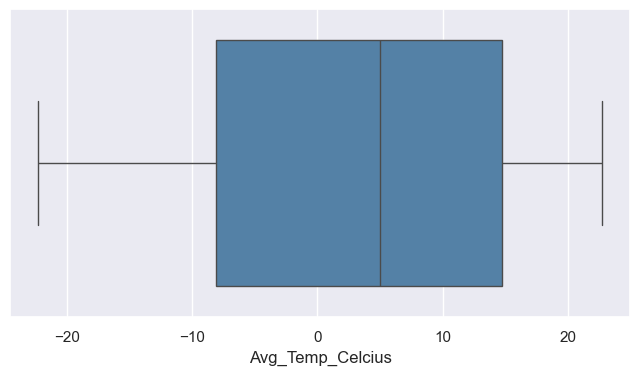

In [48]:
# Check the distribution of temperature
sns.set(rc={"figure.figsize":(8, 4)}) #set up figure size for seaboarn graphs
sns.boxplot(winnipeg_temps_mth_dt['Avg_Temp_Celcius'], orient="h", color= 'steelblue')

<Axes: xlabel='Avg_Temp_Celcius'>

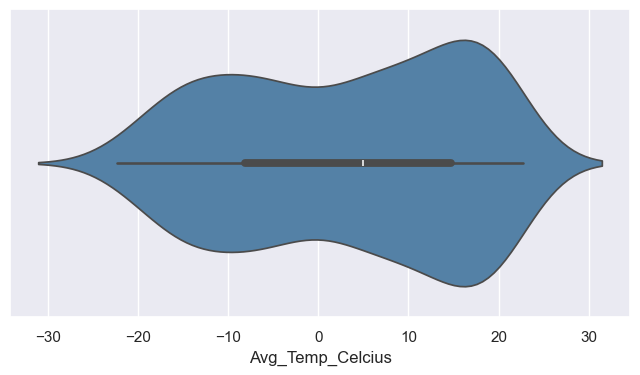

In [49]:
# Check the distribution of temperature
sns.violinplot(winnipeg_temps_mth_dt['Avg_Temp_Celcius'], orient="h", color= 'steelblue')

<Axes: xlabel='Avg_Temp_Celcius', ylabel='Count'>

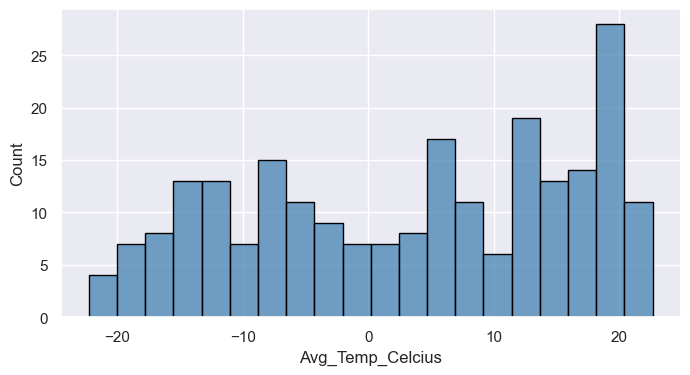

In [50]:
# Check the distribution of temperature
sns.histplot(winnipeg_temps_mth_dt['Avg_Temp_Celcius'], color= 'steelblue', bins=20, edgecolor='black')

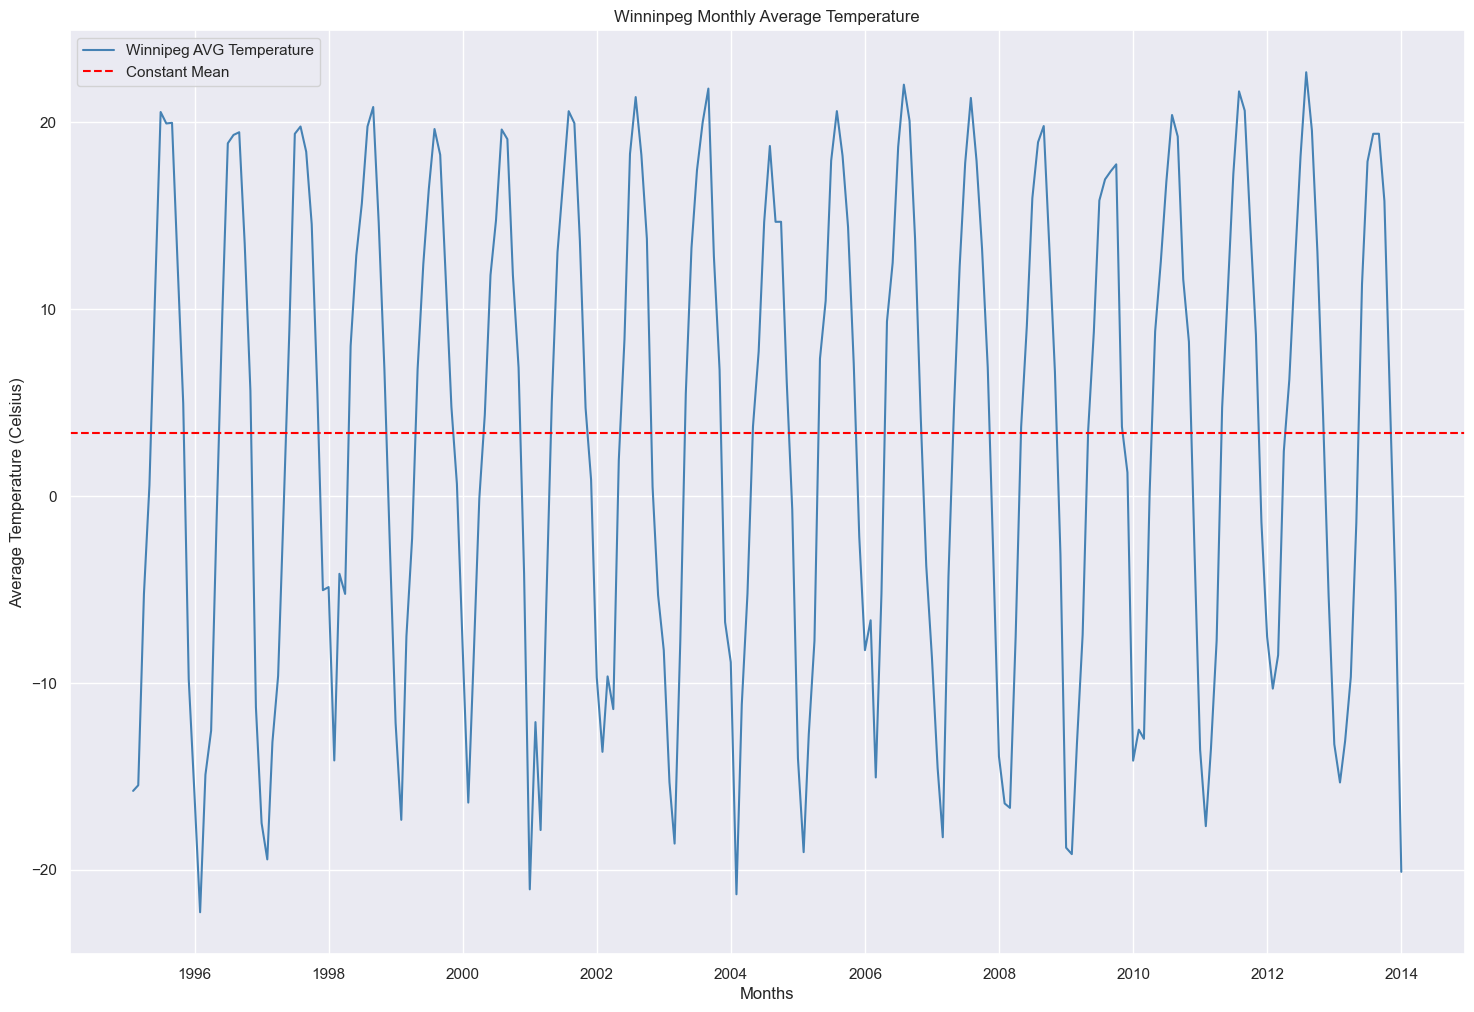

In [51]:
sns.set(rc={"figure.figsize":(18, 12)}) #set up figure size for seaboarn graphs
sns.lineplot(x='date', y='Avg_Temp_Celcius', data=winnipeg_temps_mth_dt, label='Winnipeg AVG Temperature', 
              color = 'steelblue')

plt.axhline(winnipeg_temps_mth_dt["Avg_Temp_Celcius"].mean(), ls='--', label='Constant Mean',
            color='red')
plt.title("Winninpeg Monthly Average Temperature")
plt.xlabel("Months")
plt.ylabel("Average Temperature (Celsius)")
plt.legend()

The new data frame contains a total of 228 records. Temperature ranges from -30 to 30 degrees Celsius, illustrating a broad spectrum of climate conditions.

The box plot and violin plot indicate no outliers, with the 50th percentile registering at 5 degrees Celsius. This suggests a relatively consistent distribution of temperatures across the dataset. Analyzing this to the daily data, we observe a more uniform distribution, with 25 samples clustered (highest) around an average temperature of 20 degrees Celsius.

In the line plot, the data appears notably more stable than the daily records, which often exhibit white noise. Over time, there is a discernible trend showing a slight increase in temperature. However, significant seasonality persists, evident in the annual cycle from winter to summer."
This revision provides a clearer and more detailed description of the data characteristics and observations from the analysis

#### Analyze Additive Decomposition to investigate Average Temperature (Celcius) behaviour

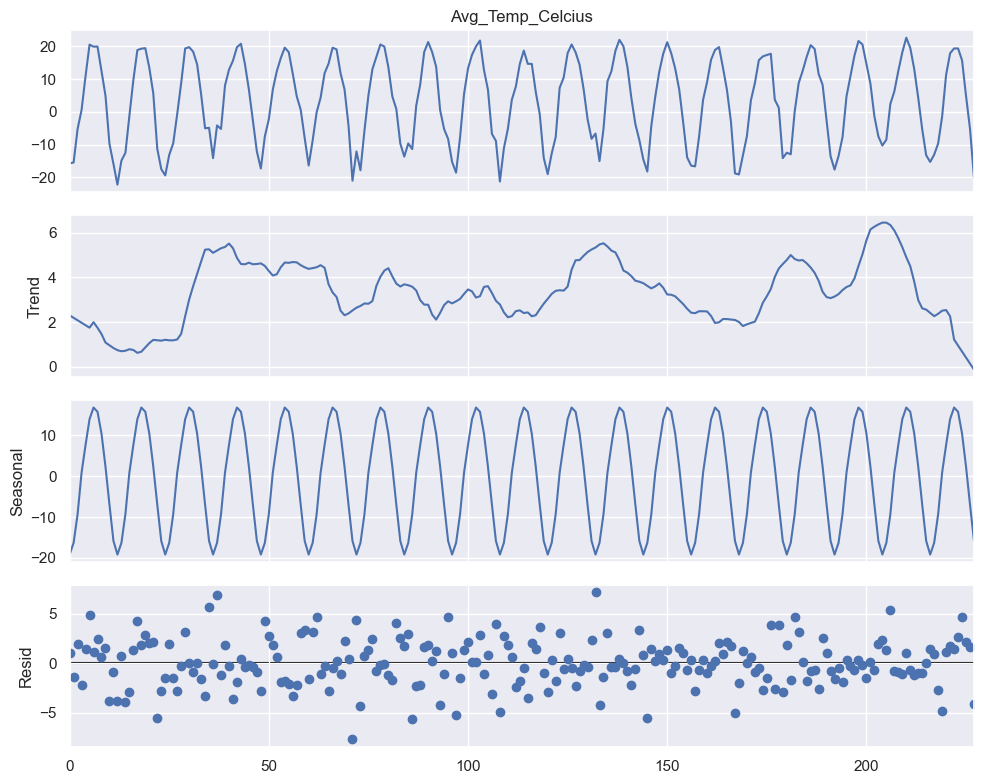

In [52]:
# Make the tests of Additive Decomposition
result_add_decom = seasonal_decompose(winnipeg_temps_mth_dt['Avg_Temp_Celcius'], model='additive',  extrapolate_trend='freq',period=12)

# Plot the results
plt.rcParams.update({'figure.figsize': (10,8)})
result_add_decom.plot()#.title('Additive Decomposition for Average Temperature (Celcius)', fontsize=15)
plt.show()

The Additive Decomposition plots above presents that the average temperature trend is quite stable, along with its obvious seasonality.

#### Checking for Stationarity Using Adfuller Test
Note: Data is stationary if p-value < 0.05 

In [53]:
# Gather p-value 
print("P-Value: ",adfuller(winnipeg_temps_mth_dt['Avg_Temp_Celcius'], autolag = 'AIC')[1])

P-Value:  0.0030988192223410345


## Models

#### Split the Winnipeg dataset in train and test datasets
It will be added to the training dataset monthly average temperatures from 1995 to 2009. The following years of monthly average temperatures will be used in the test dataset. 

In [54]:
train_mth_avg_temp = winnipeg_temps_mth_dt[winnipeg_temps_mth_dt['date'] < '2010-01-01']
test_mth_avg_temp = winnipeg_temps_mth_dt[winnipeg_temps_mth_dt['date'] >= '2010-01-01']

# check records for the train df
train_mth_avg_temp.tail()

,date,Avg_Temp_Celcius
175,2009-08-31,17.377419
176,2009-09-30,17.746667
177,2009-10-31,3.706452
178,2009-11-30,1.256667
179,2009-12-31,-14.161290


In [55]:
# check records for the train df
test_mth_avg_temp.head()

,date,Avg_Temp_Celcius
180,2010-01-31,-12.506452
181,2010-02-28,-12.992857
182,2010-03-31,0.164516
183,2010-04-30,8.803333
184,2010-05-31,12.551613


### [SARIMA](https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/)

**Concept:**
"Seasonal Autoregressive Integrated Moving Average (SARIMA) is a versatile and widely used time series forecasting model. It’s an extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns. SARIMA captures both short-term and long-term dependencies within the data, making it a robust tool for forecasting. It combines the concepts of autoregressive (AR), integrated (I), and moving average (MA) models with seasonal components."

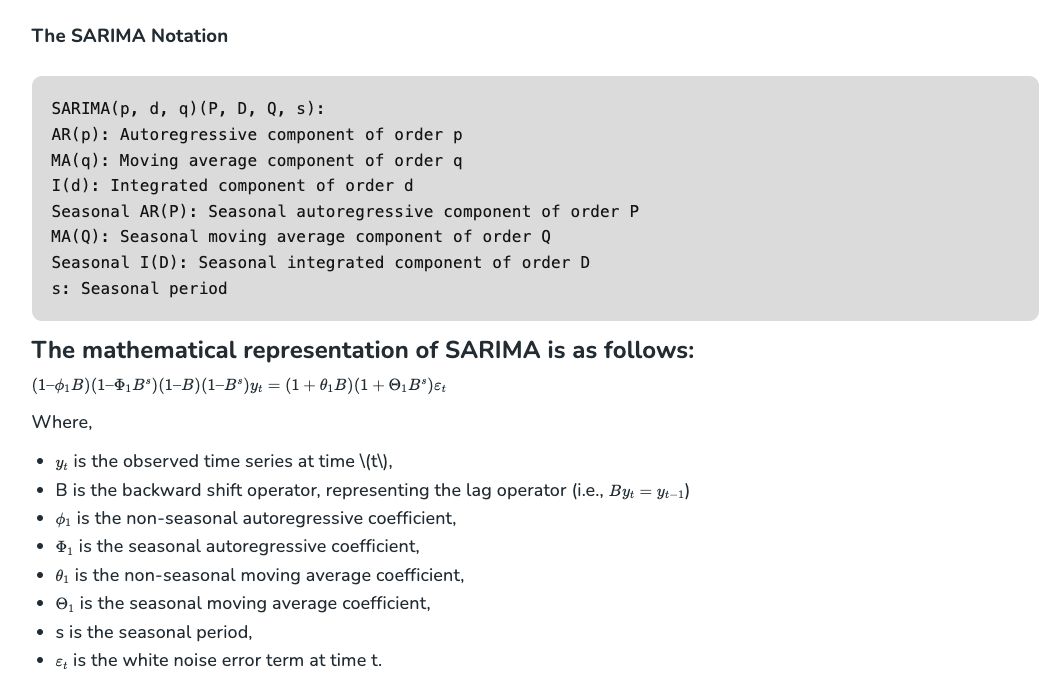

In [56]:
# Embed SARIMA notation image
display.Image("/Users/hugobritto/Desktop/MSDS/intro_ml/images/SARIMA_notation.png")

#### Find the best parameters for the SARIMA model using Akaike Information Criterion (AIC)

In [57]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Find the best sarima parameters
best_aic = 0
for p in pdq:
    for s in seasonal_pdq:
        try:
            s_mod = sm.tsa.statespace.SARIMAX(train_mth_avg_temp['Avg_Temp_Celcius'],
                                            order=p,
                                            seasonal_order=s,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results_sarima = s_mod.fit(disp=0)
            
            if best_aic == 0: # add the first results
                best_p = p
                best_s = s
                best_aic = results_sarima.aic
            if results_sarima.aic < best_aic: #check if the stored AIC is greater than the new, if yes, replace variables values
                best_p = p
                best_s = s
                best_aic = results_sarima.aic
            else:
                continue   
            print('SARIMA parameters {}x{} - AIC:{}'.format(best_p, best_s, best_aic))
        except:
            continue

SARIMA parameters (0, 0, 0)x(0, 0, 1, 12) - AIC:1207.8070597996723
SARIMA parameters (0, 0, 0)x(0, 1, 0, 12) - AIC:922.4312619508967
SARIMA parameters (0, 0, 0)x(0, 1, 1, 12) - AIC:811.3438860146559
SARIMA parameters (0, 0, 1)x(0, 1, 1, 12) - AIC:803.3850435503437
SARIMA parameters (0, 1, 1)x(0, 1, 1, 12) - AIC:798.7133961682241
SARIMA parameters (1, 0, 1)x(0, 1, 1, 12) - AIC:798.2480631194528
SARIMA parameters (1, 0, 1)x(1, 1, 1, 12) - AIC:797.176806795539


##### The lowest AIC found was 797.1768 with the SARIMA parameters (1, 0, 1) x (1, 1, 1, 12) with 12 yields.

In [58]:
# create model
sarima_model = sm.tsa.statespace.SARIMAX(train_mth_avg_temp['Avg_Temp_Celcius'],
                                            order=(1, 0, 1),
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=0)

# check results
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                   Avg_Temp_Celcius   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -393.588
Date:                            Tue, 25 Jun 2024   AIC                            797.177
Time:                                    11:37:26   BIC                            812.362
Sample:                                         0   HQIC                           803.345
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8369      0.100      8.361      0.000       0.641       1.033
ma.L1         -0.7247      0.140   

Log Likelihood: -393.588. A higher log likelihood indicates a better fit, suggesting this model fits the data reasonably well.
AIC, BIC, HQIC: These information criteria are used for model selection, with lower values indicating a better fit. Here, AIC is 797.177, BIC is 812.362, which are competitive and suggest that the model is adequately specified.

The SARIMAX(1, 0, 1)x(1, 1, 1, 12) model seems to capture both non-seasonal and seasonal dynamics in the temperature data adequately.
The coefficients indicate significant relationships with both the recent past (lag 1) and seasonal patterns (lag 12).
Diagnostic tests show no significant autocorrelation at lag 1, but there may be non-normality and potential heteroskedasticity in the residuals.

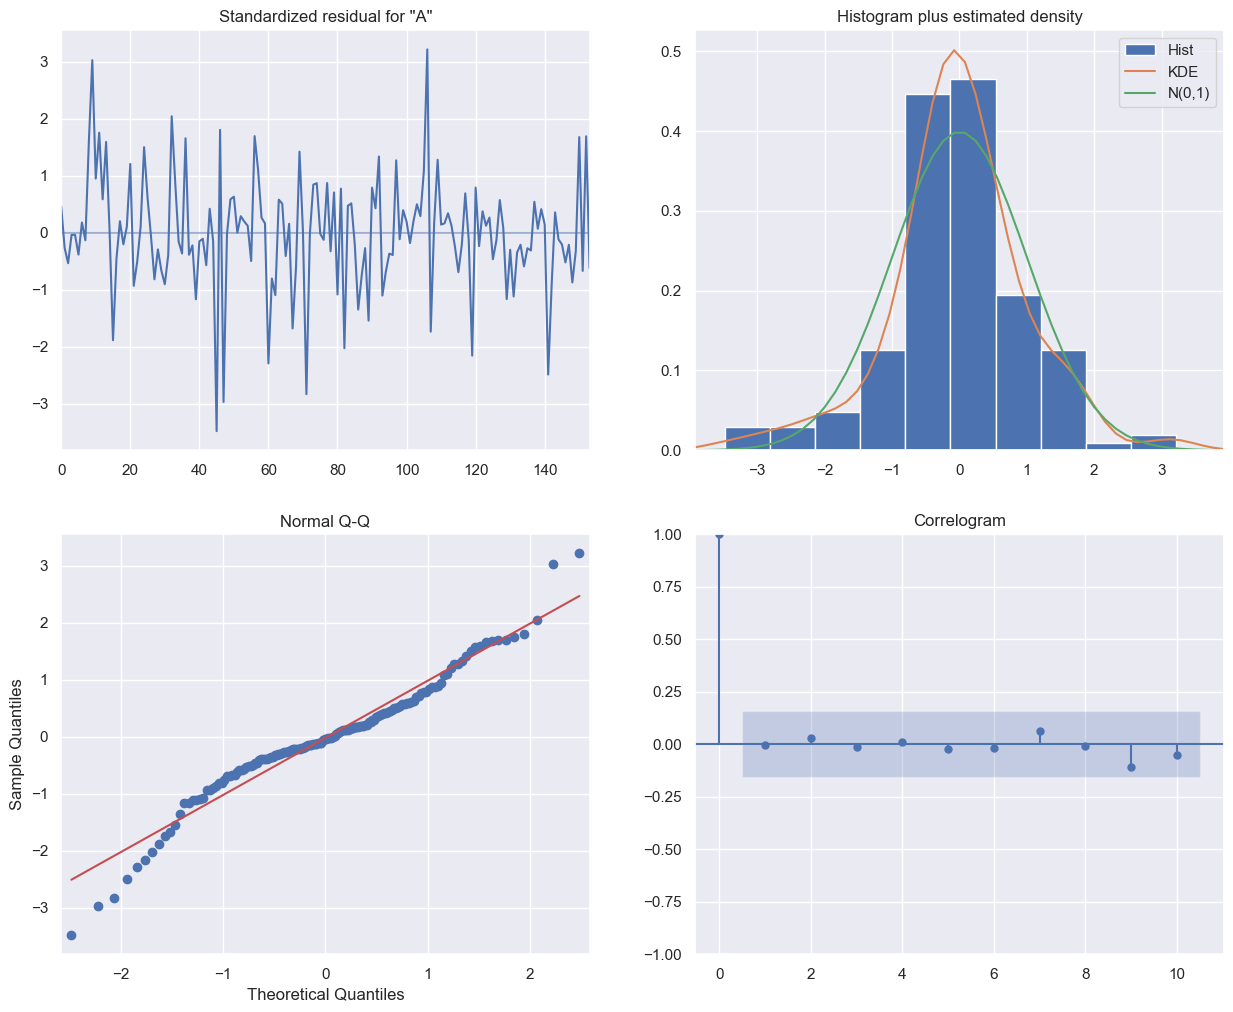

In [59]:
# Plot Model Diagnostics to investigate residuals
sarima_result.plot_diagnostics(figsize=(15,12))
plt.show()

#### Residual Analyses

Examining the residuals over time in the top-left plot, there is no apparent seasonality, and they appear to exhibit characteristics of white noise. This observation is supported by the autocorrelation plot (correlogram) in the bottom-right corner, which indicates low correlation between the residuals and their lagged values.

In the top-right plot, we observe that the red KDE line closely tracks the N(0,1) line, where N(0,1) denotes a normal distribution with mean 0 and standard deviation of 1. This suggests that the residuals are approximately normally distributed.

The qq-plot in the bottom-left corner illustrates that the ordered residuals (depicted as blue dots) align well with the expected quantiles of a standard normal distribution, N(0,1). This further indicates that the residuals follow a normal distribution pattern.

Overall, these analyses provide strong evidence that the residuals from the model are normally distributed and exhibit no significant temporal patterns or autocorrelation.
Based on these observations, we can conclude that our model provides a satisfactory fit for understanding our time series data and making forecasts for future values. The normal distribution of residuals, absence of apparent seasonality, and low autocorrelation suggest that the model captures the underlying patterns well. This gives us confidence in using the model to analyze and predict future trends in the data.

Training the model again after each prediction, making one-step-ahead prediction each time to compare 
the actual values and predicted values in line plot (Results and Analysis section) 

In [60]:
print(f'Size of data is {winnipeg_temps_mth_dt.size} and train set size is {winnipeg_temps_mth_dt.size-24}')
one_step_pred = []
for i in range(48):
  cut_point = winnipeg_temps_mth_dt.size - 24 + i
  model = sm.tsa.statespace.SARIMAX(train_mth_avg_temp['Avg_Temp_Celcius'][:cut_point],
                                    order=(1, 0, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
  sarima_result_2 = model.fit(disp=0)
  one_step_pred.append(sarima_result_2.predict(cut_point).values[0])
  # check results for the first step (1), the step 24 (middle), and last step (47)
  if i == 1: 
    print(sarima_result.summary()) 

# add the sarima predictions to the test_mth_avg_temp df
test_mth_avg_temp.loc[:,["sarima_prediction"]] = one_step_pred

Size of data is 456 and train set size is 432
                                     SARIMAX Results                                      
Dep. Variable:                   Avg_Temp_Celcius   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -393.588
Date:                            Tue, 25 Jun 2024   AIC                            797.177
Time:                                    11:37:27   BIC                            812.362
Sample:                                         0   HQIC                           803.345
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8369      0.100      8.361      0.000       0.641  

### [Prophet](https://facebook.github.io/prophet/)

**Concept:**
"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."

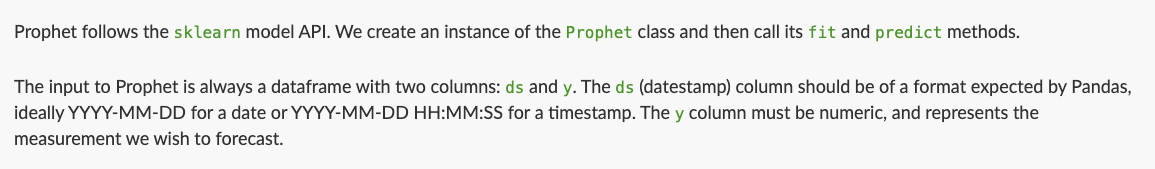

In [61]:
# Embed Prophet inputs
display.Image("/Users/hugobritto/Desktop/MSDS/intro_ml/images/Prophet_inputs.png")

In [62]:
# create a copy of the df
mth_avg_temp_prophet = winnipeg_temps_mth_dt

# convert fields name to Prophet conversion
mth_avg_temp_prophet['date'] = pd.to_datetime(mth_avg_temp_prophet['date'])
mth_avg_temp_prophet = mth_avg_temp_prophet.rename(columns={'Avg_Temp_Celcius': 'y', 'date': 'ds'})

# split dataset for the Prophet model
train_mth_avg_temp_prophet = mth_avg_temp_prophet[mth_avg_temp_prophet['ds'] < '2010-01-01']
test_mth_avg_temp_prophet = mth_avg_temp_prophet[mth_avg_temp_prophet['ds'] >= '2010-01-01']

# check records
train_mth_avg_temp_prophet.head()

,ds,y
0,1995-01-31,-15.780645
1,1995-02-28,-15.478571
2,1995-03-31,-5.241935
3,1995-04-30,0.583333
4,1995-05-31,10.964516


In [63]:
# create model
prophet_model = Prophet()
prophet_model.fit(train_mth_avg_temp_prophet)

# make predictions
prophet_model_forecast = prophet_model.predict(test_mth_avg_temp_prophet)

11:37:33 - cmdstanpy - INFO - Chain [1] start processing
11:37:33 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper
0 2010-01-31 -15.854295  -19.267668  -12.100633
1 2010-02-28 -13.024387  -16.656598   -9.401891
2 2010-03-31  -6.289581  -10.032831   -2.715450
3 2010-04-30   4.406854    0.849932    8.079100
4 2010-05-31  11.056576    7.386929   14.433406


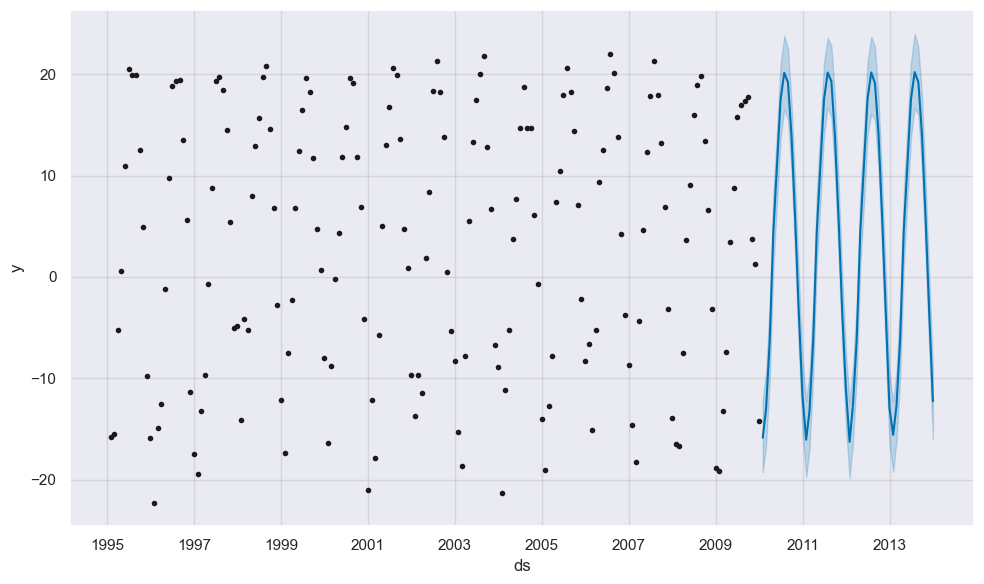

In [64]:
# summarize the prophet predictions
print(prophet_model_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# plot prophet predictions
prophet_model.plot(prophet_model_forecast)
plt.show()

The prediction period is showing a trend similar to that of the training dataset, with a slight increase over time, indicating consistent alignment in their patterns.

#### Perform Cross Validation to evaluate the model

In [65]:
# Perform cross-validation to evaluate model performance
cv_results = cross_validation(model=prophet_model,
                              initial=pd.to_timedelta(30*20, unit='D'),
                              period=pd.to_timedelta(30 * 5, unit='D'),
                              horizon=pd.to_timedelta(30*12, unit='D')
                              )
# Set a 'cutoff' date for performance evaluation
cv_results['cutoff'] = pd.to_datetime('2010-01-01')

# Calculate performance metrics using performance_metrics
df_performance = performance_metrics(cv_results)

  0%|                                                    | 0/30 [00:00<?, ?it/s]11:37:34 - cmdstanpy - INFO - Chain [1] start processing
11:37:35 - cmdstanpy - INFO - Chain [1] done processing
  3%|█▍                                          | 1/30 [00:01<00:30,  1.06s/it]11:37:35 - cmdstanpy - INFO - Chain [1] start processing
11:37:35 - cmdstanpy - INFO - Chain [1] done processing
  7%|██▉                                         | 2/30 [00:01<00:14,  1.89it/s]11:37:35 - cmdstanpy - INFO - Chain [1] start processing
11:37:35 - cmdstanpy - INFO - Chain [1] done processing
 10%|████▍                                       | 3/30 [00:01<00:10,  2.58it/s]11:37:35 - cmdstanpy - INFO - Chain [1] start processing
11:37:35 - cmdstanpy - INFO - Chain [1] done processing
 13%|█████▊                                      | 4/30 [00:01<00:07,  3.50it/s]11:37:35 - cmdstanpy - INFO - Chain [1] start processing
11:37:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|███████▎                      

In [66]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,-4172 days,26.222379,5.120779,4.009847,0.651573,0.309165,0.479500,0.228571
1,-4141 days,26.185861,5.117212,3.984860,0.648151,0.309165,0.476150,0.285714
2,-4111 days,25.786862,5.078077,3.873093,0.560891,0.234936,0.412334,0.342857
3,-4080 days,25.486930,5.048458,3.784424,0.562434,0.234936,0.413643,0.400000
4,-4050 days,25.482470,5.048016,3.796686,0.621917,0.309165,0.447869,0.428571
...,...,...,...,...,...,...,...,...
133,-123 days,7.103494,2.665238,2.081789,0.170193,0.144800,0.167442,0.800000
134,-93 days,7.293056,2.700566,2.110238,0.167466,0.144800,0.166659,0.771429
135,-62 days,7.207748,2.684725,2.093457,0.175895,0.144800,0.172257,0.771429
136,-32 days,7.734414,2.781081,2.165353,0.283506,0.144800,0.225388,0.742857


The model performance improves as the horizon decreases, moving from earlier (more distant) predictions (-4172 days) to more recent predictions (-1 day). RMSE ranges from 5.12 (at -4172 days) to 2.78 (at -1 day), indicating that the model's average prediction error decreases significantly as it approaches the present day. MAE follows a similar pattern, improving from 4.01 to 2.16 as the horizon shortens. It suggests better relative accuracy as the forecast horizon gets closer to the present. As the prediction horizon gets shorter, the model tends to make more accurate and precise forecasts, as reflected by decreasing error metrics.

In [67]:
from prophet.plot import plot_cross_validation_metric

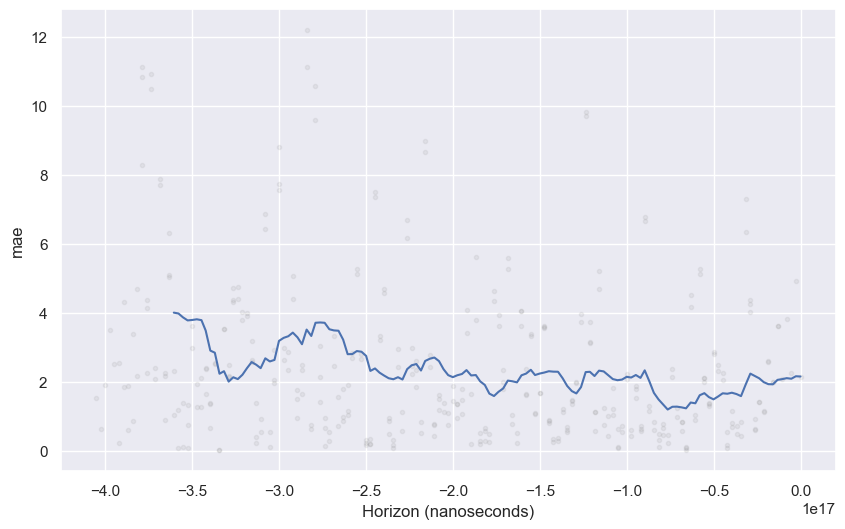

In [68]:
# Visualize performance metrics using plots
fig = plot_cross_validation_metric(cv_results, metric = 'mae')

In [69]:
# add Prophet predictions to the test_mth_avg_temp df
test_mth_avg_temp.loc[:,["prophet_prediction"]] = prophet_model_forecast['yhat'].values

# check the final test df
test_mth_avg_temp.head()

,date,Avg_Temp_Celcius,sarima_prediction,prophet_prediction
180,2010-01-31,-12.506452,-15.848631,-15.854295
181,2010-02-28,-12.992857,-12.877264,-13.024387
182,2010-03-31,0.164516,-6.313159,-6.289581
183,2010-04-30,8.803333,4.757128,4.406854
184,2010-05-31,12.551613,10.915990,11.056576


The Prophet model demonstrates reasonably good performance in forecasting, with significant improvements in accuracy metrics as the prediction horizon gets closer to the current date. This analysis suggests that the model is effective for forecasting within shorter timeframes and provides reliable prediction intervals that capture the majority of actual values. For practical applications, especially for short-term forecasting, the Prophet model appears to be a suitable choice based on these evaluation results.

## Results and Analysis

### Analyze the Accuracy of Sarima and Prophet models - Root Mean Absolute Error (RMSE)

In [70]:
# Check your Accuracy Metric
# calculate the mean absolute error across the forecasts
rmse_sarima=sqrt(mean_squared_error(test_mth_avg_temp['Avg_Temp_Celcius'], test_mth_avg_temp['sarima_prediction']))

rmse_prophet=sqrt(mean_squared_error(test_mth_avg_temp['Avg_Temp_Celcius'], test_mth_avg_temp['prophet_prediction']))

# print the root mean absolute error across the forecasts
print(f'Sarima Model Root Mean Absolute Error (RMSE): {rmse_sarima:.4f} \n')
print(f'Prophet Model Root Mean Absolute Error (RMSE): {rmse_prophet:.4f}\n')

print('The Prophet model is able to fit the dataset better than the Sarima model. Since') 
print(f'the Prophet model had {(rmse_sarima/rmse_prophet -1)*100:.3f}% less root mean absolute error than Sarima model.')

Sarima Model Root Mean Absolute Error (RMSE): 2.9087 

Prophet Model Root Mean Absolute Error (RMSE): 2.8363

The Prophet model is able to fit the dataset better than the Sarima model. Since
the Prophet model had 2.551% less root mean absolute error than Sarima model.


### Analyze the Coefficient of determination (R<sup>2</sup>)

In [71]:
# Calculate R-square performance for the models:
r2_sarima = r2_score(test_mth_avg_temp['Avg_Temp_Celcius'], test_mth_avg_temp['sarima_prediction'])

r2_prophet = r2_score(test_mth_avg_temp['Avg_Temp_Celcius'], test_mth_avg_temp['prophet_prediction'])

# print the results
print(f'Sarima Model Coefficient of determination (R-square): {r2_sarima:.4f} \n')
print(f'Prophet Model Coefficient of determination (R-square): {r2_prophet:.4f}\n')
print(f'Prophet model explained {(r2_prophet/r2_sarima -1)*100:.3f}% more variance in temperature data than the Sarima model')

Sarima Model Coefficient of determination (R-square): 0.9486 

Prophet Model Coefficient of determination (R-square): 0.9511

Prophet model explained 0.266% more variance in temperature data than the Sarima model


### Analyze the Line Plot with Actual vs. Predicted Average Temperature Values

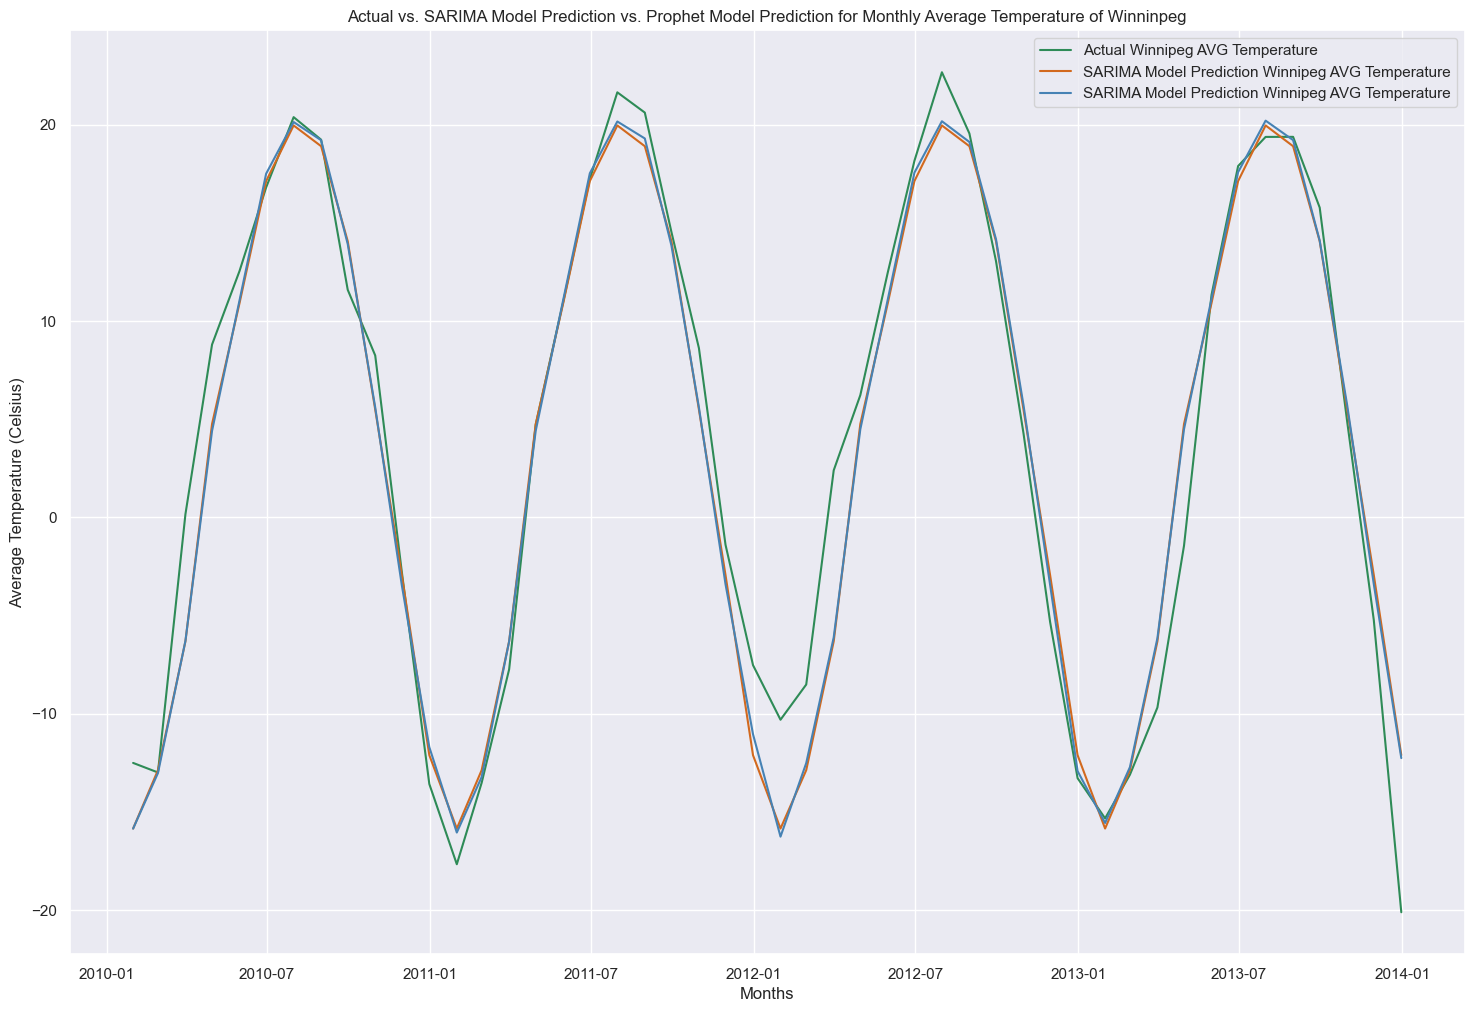

In [72]:
sns.set(rc={"figure.figsize":(18, 12)}) #set up figure size for seaboarn graphs
sns.lineplot(x='date', y='Avg_Temp_Celcius', data=test_mth_avg_temp, label='Actual Winnipeg AVG Temperature', 
              color = 'seagreen')
sns.lineplot(x='date', y='sarima_prediction', data=test_mth_avg_temp, label='SARIMA Model Prediction Winnipeg AVG Temperature', 
              color = 'chocolate')
sns.lineplot(x='date', y='prophet_prediction', data=test_mth_avg_temp, label='SARIMA Model Prediction Winnipeg AVG Temperature', 
              color = 'steelblue')
plt.title("Actual vs. SARIMA Model Prediction vs. Prophet Model Prediction for Monthly Average Temperature of Winninpeg")
plt.xlabel("Months")
plt.ylabel("Average Temperature (Celsius)")
plt.legend()

The SARIMA and Prophet models performed well overall in predicting temperature values compared to actual data, but they faced a notable challenge during the first quarter of 2012. This period, marking the winter with the highest temperatures in the dataset, saw a significant discrepancy: both models predicted temperatures around -15 degrees Celsius, while the actual temperature was -10 degrees Celsius—a difference of approximately 5 degrees.

Addressing such outliers presents a significant challenge, especially considering this anomaly occurred only once in 17 years of data.

In terms of model comparison, the Prophet model showed slightly better performance than SARIMA. The Prophet model achieved a Root Mean Absolute Error (RMSE) of 2.8363, compared to SARIMA's 2.9834, indicating Prophet was closer to actual temperature values on average. This difference in RMSE translates to a 5.188% improvement in accuracy for the Prophet model over SARIMA.

Moreover, examining the coefficient of determination (R-squared), the Prophet model again outperformed SARIMA by explaining 0.266% more variance in the temperature data. Specifically, SARIMA had an R-squared of 0.9486, whereas Prophet achieved 0.9511, indicating Prophet's better ability to capture variability and trends in the temperature dataset.



## Discussion and Conclusion

In conclusion, our exploration into SARIMA and Prophet models for temperature forecasting revealed notable insights into their respective strengths and challenges. Both models demonstrated strong predictive capabilities, with Prophet exhibiting slightly superior performance, particularly in accuracy and variance explanation. This suggests that Prophet may be better suited for tasks requiring precise forecasting in varying conditions.

However, it's important to note that exceptional outlier events, such as the winter of 2012, pose ongoing challenges for predictive models. Addressing these outliers effectively remains a crucial area for future improvements.
In practice, further investigation into the non-normality and heteroskedasticity of residuals is recommended when using these models. This analysis can guide potential refinements to enhance forecasting accuracy.

Based on our findings, the SARIMAX model emerges as a practical choice for forecasting Avg_Temp_Celsius. Its flexibility in parameter tuning allows for nuanced adjustments that can better capture complex temporal patterns.
Regarding usability, Prophet stands out for its simplicity; it doesn't require extensive parameter tuning and involves straightforward dataset preparation. On the other hand, SARIMA provides greater flexibility through manual parameter specification, making it suitable for projects where fine-tuning is critical.

Ultimately, the choice between Prophet and SARIMA hinges on the specific requirements and nuances of each forecasting project. While Prophet offers simplicity and strong out-of-the-box performance, SARIMA provides flexibility and customization capabilities that can be advantageous in certain scenarios. Therefore, selecting the optimal model depends on balancing these factors against project goals and data characteristics.